# Exploring Wikipedia's Network Structure in a Temporal Fashion
Authors: Felix Borum Burmester & Christian Vestergaard Djurhuus.

In this notebook, we will explore the temporal development of Marvel- and DC-Comics. We have used the Wikipedia Revisions api to scrape the Wikipedia pages of 2303 superheroes since the dawn of Wikipedia. We have used these pages to create a directed, temporal graph object that will allow us to understand the development of revisions.

We have also webscraped meta data from lists of female, black, latino, and asian superheroes and villains. With this meta data we were able to appoint node attributes to our graph with the help of document similarity (since different websites may call superheroes by different versions of their names).

<img src="G_plot_final.gif" width="750" align="center">

The red nodes here are Marvel characters, and the blue are DC characters!

This investigative notebook will attempt to discover characteristics about the network as well as investigate to its evolution. This will be done by exploring basic statistics of the network and how they evolve, how communities evolve and finally how communities change with time in the network.

Furthermore, with the metadata we have webscraped, we want to investigate whether Wikipedia revisions have followed the same trend as the rest of the world to include more diversity.

Let's explore the data and its attributes!



## Revision Analysis

Wikipedia is an online encyclopedia that is created and altered by a community of volunteers from all over the world. Hence, the content of a Wikipedia page may be changed through revisions conducted by the volunteers. The revisions of a given Wikipedia page are timestamped, stored and made publicly available by the Wikipedia Revisions API. This allows individuals to analyse how the content of Wikipedia changes with time.

The content of a Wikipedia page often references other Wikipedia pages using hyperlinks, which allow us to represent Wikipedia as a directed network $G=(\mathcal{N}, \mathcal{V})$, where the pages correspond to the nodes $\mathcal{N}$ and hyperlinks between Wikipedia pages corresponds to the edges/links $\mathcal{V}$.

In our specific case, we want to investigate and understand a minor subset of the Wikipedia network focusing on how the superhero pages of Wikipedia reference each other. However, instead of analysing the static Wikipedia network, we will use the Wikipedia Revisions API to gather the different versions of the superhero pages from 2001 to 2022. We have decided to discretise the time interval by querying the last revision of a superhero page each year. This allows us to represent the superhero Wikipedia link network as a temporal network using a sequence of static networks corresponding to each year. The usage of a temporal network instead of a static network will allow us to investigate how the network has evolved from its origin to this date.

The wiring of the temporal network is changed by the volunteers' revisions, e.g., when they either add or remove a hyperlink to another Wikipedia page. Therefore, the first part of this notebook will investigate the number of revisions as a function of time to get an initial impression of the revision distribution and how frequent the structure of the temporal network may be altered:


In [7]:
import pickle
import os
import io
import re
import networkx as nx
import netwulf as nw 
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

In [8]:
df_marvel = pd.read_csv("files/marvel.csv", index_col=0, encoding='utf8')
df_marvel = df_marvel[df_marvel["WikiLink"].notna()]
df_dc = pd.read_csv("files/dc.csv", index_col=0, encoding='utf8')
df_dc = df_dc[df_dc["WikiLink"].notna()]
df_marvel['universe'] = 'Marvel'
df_dc['universe'] = 'DC'
df = pd.concat([df_marvel, df_dc], ignore_index=True, axis=0)
edgelist = pd.read_csv("corrected_edgelist.csv")
edgelist = edgelist.drop_duplicates(ignore_index=True)

In [9]:
path_folder = 'superheroes/'
df_revisions = pd.DataFrame()
df_revisions

total_counts = dict.fromkeys([2000 + n for n in range(1, 2022-2001 + 2)], 0)

for idx, row in tqdm(df.iterrows()):
    try:
        with open(path_folder + row.CharacterName + '/' + 'number_of_revisions.pkl', 'rb') as handle:
            revision_counts = pickle.load(handle)
            for key, item in revision_counts.items():
                total_counts[key] += item
    except Exception as e:
        pass
        #print(f'An error occured: {e}')

for idx, row in tqdm(df.iterrows()):
    try:
        with open(path_folder + row.CharacterName + '/' + 'number_of_revisions.pkl', 'rb') as handle:
            revision_counts = pickle.load(handle)
        temp_rv_df = pd.DataFrame.from_dict({'counts':revision_counts.values(), 'Year':revision_counts.keys(), 'Character':[row.CharacterName]*len(list(revision_counts.keys()))})
        df_revisions = df_revisions.append(temp_rv_df, ignore_index=True)
    except Exception as e:
        #print(f'An error occured: {e}')
        pass

2303it [00:00, 2723.66it/s]
2303it [00:03, 673.54it/s]


The following figure illustrates the total number of revisions within a specific year for the superheroes wikipedia pages:

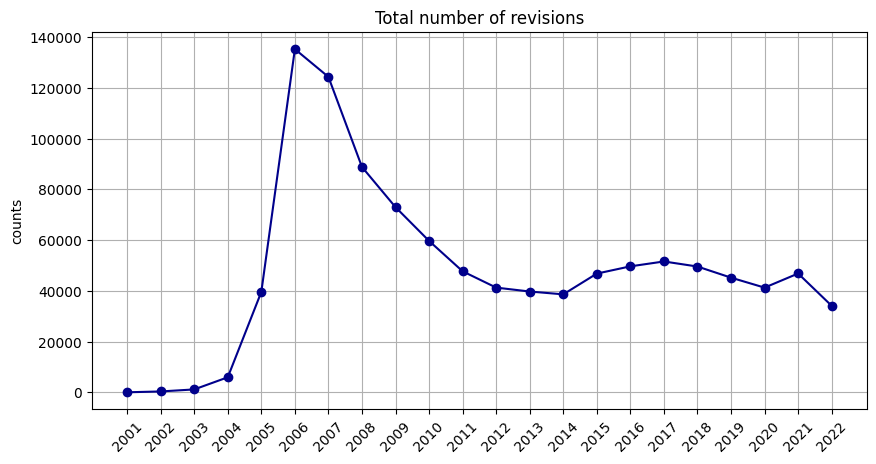

In [10]:
fig, ax = plt.subplots(figsize=(10,5), dpi=100)
ax.plot([str(item) for item in list(total_counts.keys())], list(total_counts.values()), '-o', c='darkblue')
ax.grid()
ax.set_ylabel("counts")
ax.set_title("Total number of revisions")
plt.xticks(rotation=45)
plt.show()

It seems that revisions were at a peak during the big boom in Wikipedia (2004-2007). After this, the revisions slowly decline. It seems, however, that during the movies of the MCU and DCU, the revisions reached a new peak.

In [11]:
#from pandas.api.types import CategoricalDtype

#cat_character = CategoricalDtype(df_revisions.Character.unique())
#df_revisions['Character'] = df_revisions['Character'].astype(cat_character)
metadata = pd.read_csv('metadataproject.csv')
temp = pd.merge(df_revisions, metadata, left_on='Character', right_on='CharacterName') 
#Creating female and male dataframe
df_male = temp[temp['man']==1]
df_women = temp[temp['woman']==1]

counts_women = df_women.groupby(['Year']).sum().counts
counts_men =  df_male.groupby(['Year']).sum().counts

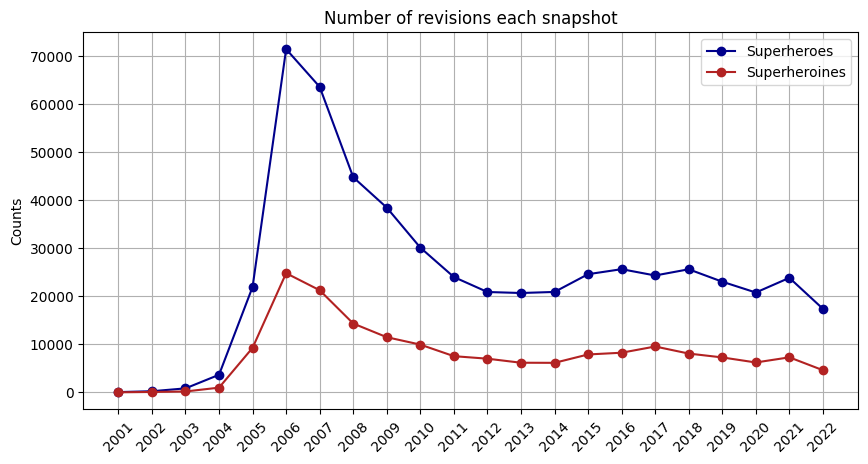

In [12]:
fig, ax = plt.subplots(figsize=(10,5), dpi=100)
ax.plot(counts_men.index.astype(str), counts_men.values, '-o', c='darkblue', label="Superheroes")
ax.plot(counts_women.index.astype(str), counts_women.values, '-o', c='firebrick', label="Superheroines")
ax.set_ylabel("Counts")
ax.set_title("Number of revisions each snapshot")
ax.grid()
ax.legend()
plt.xticks(rotation=45)
plt.show()

There seems to be almost the same trend with the exception that 2017 seems to be a small peak for superheroines and a valley for superheroes. Overall, however, there are more revisions on superheroes than on superheroines during the entire period.

## Exploration of Basic Stats in Network
### Node Analysis
Let's view the number of nodes with each label by time:

In [13]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

def setup_mpl():
    mpl.rcParams['font.family'] = "Times New Roman"
    return
setup_mpl()

#import data
meta_df = pd.read_csv('metadataproject.csv')
edgelist = pd.read_csv('corrected_edgelist.csv')

In [14]:
meta_df.head()

Unnamed: 0  CharacterName                 WikiLink universe  asian  latino  \
0           0    Abomination  Abomination (character)   Marvel      0       0   
1           1  Absorbing Man            Absorbing Man   Marvel      0       0   
2           2         Achebe          Achebe (comics)   Marvel      0       0   
3           3          Agent           Agent (comics)   Marvel      0       0   
4           4        Agent X  Agent X (Marvel Comics)   Marvel      0       0   

   woman  black  man  good  bad  
0      0      0    1     0    1  
1      0      0    1     0    1  
2      0      0    0     0    0  
3      0      0    1     1    0  
4      0      0    1     1    0

As you can see, there is not meta data for all nodes; Achebe has no gender, race or alignment in our data..

In [15]:
edgelist.head()

source                target  timestamp
0  Abomination (character)         Silver Surfer       2014
1  Abomination (character)  Thor (Marvel Comics)       2014
2  Abomination (character)     Sprocket (comics)       2014
3  Abomination (character)          Glenn Talbot       2014
4  Abomination (character)                 MODOK       2014

The edgelist has timestamps for when the link is valid. This is used to later create time-specific snapshots of the graph!

Now we create a node list and merge it with our meta data

In [16]:
sourcenodes = pd.DataFrame(np.array(list(edgelist.groupby(['source','timestamp']).groups.keys())), columns = ['node','timestamp'])
targetnodes = pd.DataFrame(np.array(list(edgelist.groupby(['target','timestamp']).groups.keys())), columns = ['node','timestamp'])
#keep unique nodes and timestamps!
nodes =  pd.concat([sourcenodes,targetnodes]).drop_duplicates().reset_index(drop=True)

temp = meta_df.rename(columns={'WikiLink':'node'})
nodes = pd.merge(nodes, temp, on="node")
nodes = nodes.drop(columns=['Unnamed: 0'])
nodes.head()

node timestamp CharacterName universe  asian  latino  woman  black  man  \
0  3-D Man      2007       3-D Man   Marvel      0       0      0      0    1   
1  3-D Man      2008       3-D Man   Marvel      0       0      0      0    1   
2  3-D Man      2009       3-D Man   Marvel      0       0      0      0    1   
3  3-D Man      2010       3-D Man   Marvel      0       0      0      0    1   
4  3-D Man      2011       3-D Man   Marvel      0       0      0      0    1   

   good  bad  
0     1    0  
1     1    0  
2     1    0  
3     1    0  
4     1    0

We need some pd.series to plot, so we use groupby and its features to get them and create three plots:

In [17]:
#get plotable data for marvel and dc
total_nodes_by_year = nodes.groupby('timestamp').size()
temp = nodes.groupby(['universe'])
dc_nodes_by_year, marvel_nodes_by_year = [temp.get_group(x) for x in temp.groups]
dc_nodes_by_year = dc_nodes_by_year.groupby('timestamp').size()
marvel_nodes_by_year = marvel_nodes_by_year.groupby('timestamp').size()

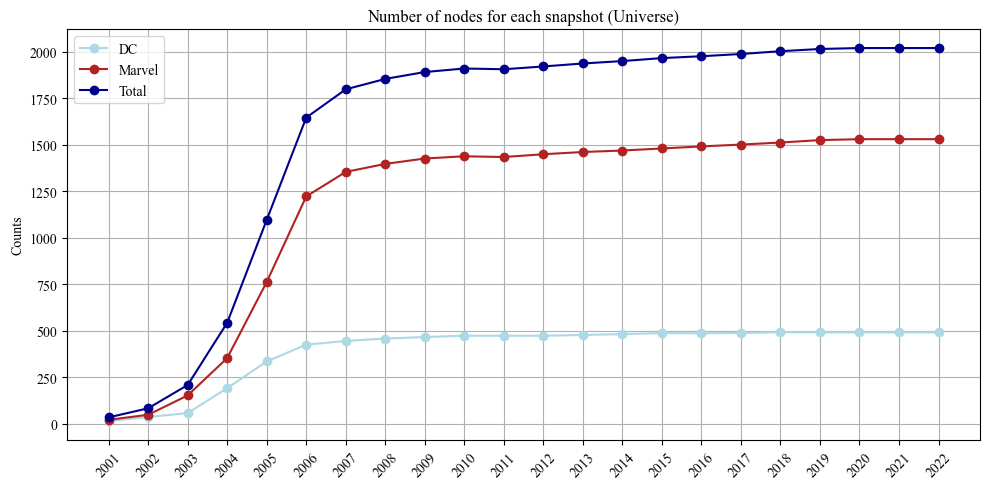

In [18]:
fig, ax = plt.subplots(figsize=(10,5), dpi=100)
ax.plot(dc_nodes_by_year.index, dc_nodes_by_year.values, '-o', c='lightblue', label='DC')
ax.plot(marvel_nodes_by_year.index, marvel_nodes_by_year.values, '-o', c='firebrick', label='Marvel')
ax.plot(total_nodes_by_year.index, total_nodes_by_year.values, '-o', c='darkblue',label='Total')
ax.set_title("Number of nodes for each snapshot (Universe)")
ax.set_ylabel("Counts")
ax.grid()
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

We see here that there is a surge in number of nodes from 2003 to 2007 where it looks like it is more stable with a slight upwards trend. This might overshadow further analysis of the graph. One might consider making a cut and only view the data from 2007 to 2022.

Let's view some other features in the data!

In [19]:
#get plotable data for sex, race and alignment!
temp = nodes.groupby(['man'])
man_nodes_by_year = [temp.get_group(x) for x in temp.groups][1].groupby('timestamp').size()
temp = nodes.groupby(['woman'])
woman_nodes_by_year = [temp.get_group(x) for x in temp.groups][1].groupby('timestamp').size()
temp = nodes.groupby(['asian'])
asian_nodes_by_year = [temp.get_group(x) for x in temp.groups][1].groupby('timestamp').size()
temp = nodes.groupby(['latino'])
latino_nodes_by_year = [temp.get_group(x) for x in temp.groups][1].groupby('timestamp').size()
temp = nodes.groupby(['black'])
black_nodes_by_year = [temp.get_group(x) for x in temp.groups][1].groupby('timestamp').size()
temp = nodes.groupby(['good'])
good_nodes_by_year = [temp.get_group(x) for x in temp.groups][1].groupby('timestamp').size()
temp = nodes.groupby(['bad'])
bad_nodes_by_year = [temp.get_group(x) for x in temp.groups][1].groupby('timestamp').size()

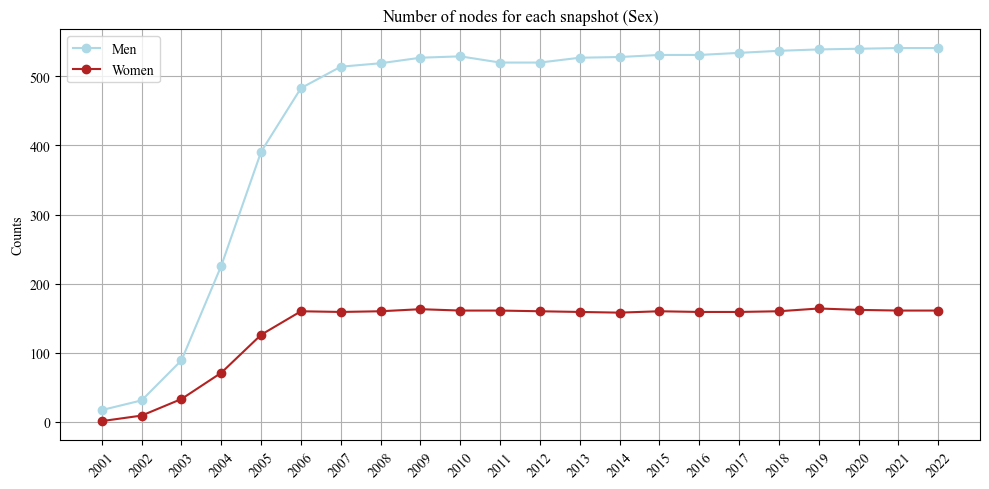

In [20]:
fig, ax = plt.subplots(figsize=(10,5), dpi=100)
ax.plot(man_nodes_by_year.index, man_nodes_by_year.values, '-o', c='lightblue', label='Men')
ax.plot(woman_nodes_by_year.index, woman_nodes_by_year.values, '-o', c='firebrick', label='Women')
ax.set_title("Number of nodes for each snapshot (Sex)")
ax.set_ylabel("Counts")
ax.grid()
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The same surge-trend seems to be present here as well. There is no indication from this plot that wokeism have created more superheroine wikipedia articles at least. Let's see the same plot with everything pre 2007 cut off:

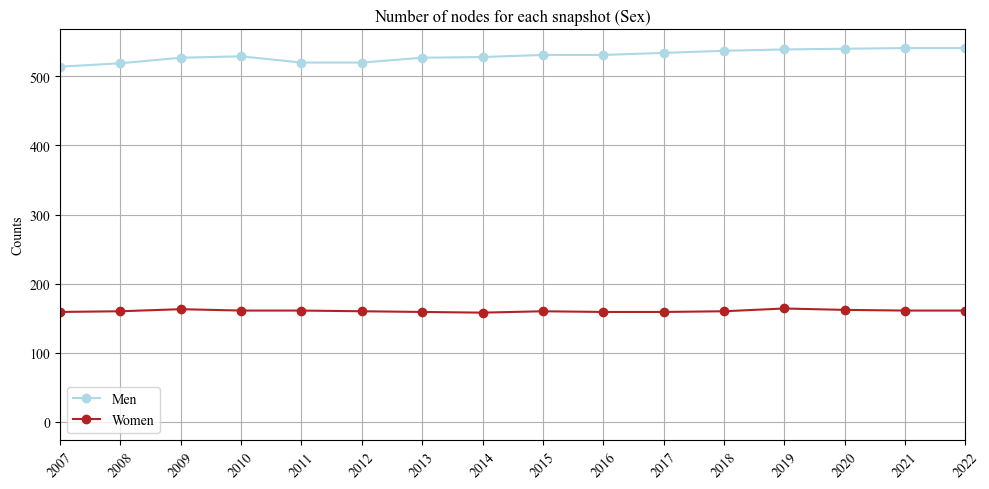

In [21]:
fig, ax = plt.subplots(figsize=(10,5), dpi=100)
ax.plot(man_nodes_by_year.index, man_nodes_by_year.values, '-o', c='lightblue', label='Men')
ax.plot(woman_nodes_by_year.index, woman_nodes_by_year.values, '-o', c='firebrick', label='Women')
ax.set_title("Number of nodes for each snapshot (Sex)")
ax.set_ylabel("Counts")
ax.grid()
ax.legend()
plt.xlim('2007','2022')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Our verdict does not change.. But what about race?

It was not possible to find any list of caucasian superheroes or villains. You might be able to conclude that the rest are white, but as some superheroes or villains are aliens, it would not be correct to assume them to be white. "Why not find a list of extraterestial superheroes?" Well, Thor, Loki and Odin are extraterestial but they are also caucasian. We found it best not to mess with this as the data would be highly inaccurate.

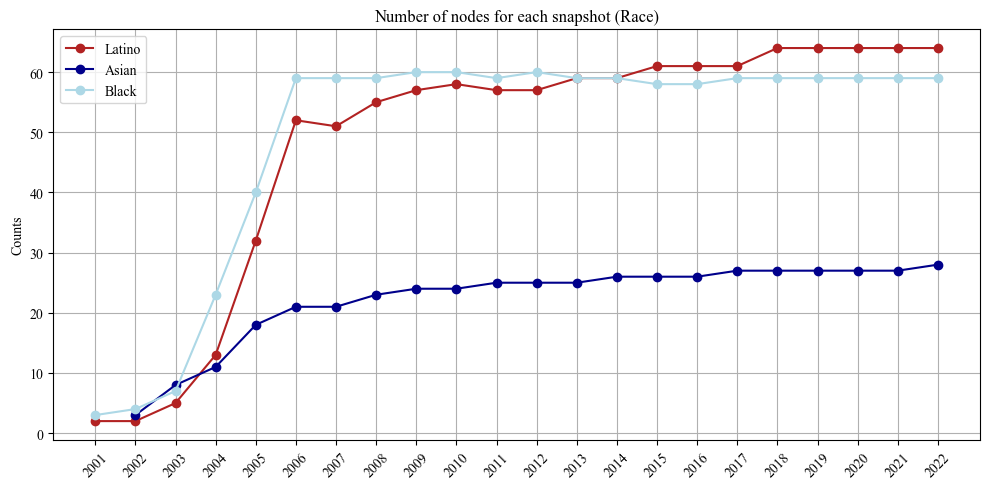

In [22]:
fig, ax = plt.subplots(figsize=(10,5), dpi=100)
ax.plot(latino_nodes_by_year.index, latino_nodes_by_year.values, '-o', c='firebrick', label='Latino')
ax.plot(asian_nodes_by_year.index, asian_nodes_by_year.values, '-o', c='darkblue',label='Asian')
ax.plot(black_nodes_by_year.index, black_nodes_by_year.values, '-o', c='lightblue',label='Black')
ax.set_title("Number of nodes for each snapshot (Race)")
ax.set_ylabel("Counts")
ax.grid()
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Here we see some interesting trends. The number of Wiki articles for Latinos and Asians seem to steadily increase while Black superhero articles seem to decline. Perhaps this is worth further exploration in the project?

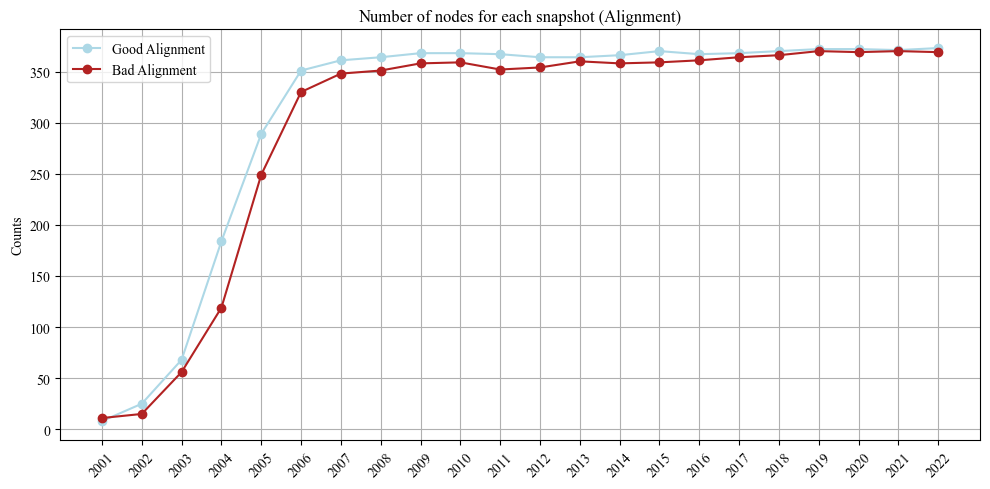

In [23]:
fig, ax = plt.subplots(figsize=(10,5), dpi=100)
ax.plot(good_nodes_by_year.index, good_nodes_by_year.values, '-o', c='lightblue', label='Good Alignment')
ax.plot(bad_nodes_by_year.index, bad_nodes_by_year.values, '-o', c='firebrick',label='Bad Alignment')
ax.set_title("Number of nodes for each snapshot (Alignment)")
ax.set_ylabel("Counts")
ax.grid()
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

It makes sense that there would be about the same number of superheros as super villains (and that the trends would follow each other closely).

All plots of nodes seem to follow the general Wikipedia trend ([with the massive surge in 2003-2006](https://en.wikipedia.org/wiki/Wikipedia:Statistics)). It is still interesting that there have been a lot more pages created on male superheroes as compared to female superheroes in general. This could indicate that there are more male superheroes to create articles about and that the ones creating articles are more interested in them (perhaps because they are males themselves).

### Edge Analysis
In the following, the evolution of number of edges in the temporal Wikipedia-link superhero network will be investigated. To evaluate the evolution, we have decided to represent the temporal network as a sequence of static networks corresponding to a yearly snapshot of the original temporal network.

In [24]:
import os
import io
import re
import networkx as nx
import netwulf as nw 
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

In [25]:
df_marvel = pd.read_csv("files/marvel.csv", index_col=0, encoding='utf8')
df_marvel = df_marvel[df_marvel["WikiLink"].notna()]
df_dc = pd.read_csv("files/dc.csv", index_col=0, encoding='utf8')
df_dc = df_dc[df_dc["WikiLink"].notna()]
df_marvel['universe'] = 'Marvel'
df_dc['universe'] = 'DC'
df = pd.concat([df_marvel, df_dc], ignore_index=True, axis=0)
edgelist = pd.read_csv("corrected_edgelist.csv")
edgelist = edgelist.drop_duplicates(ignore_index=True)

The following figure illustrates the total number of edges at each yearly snapshot.

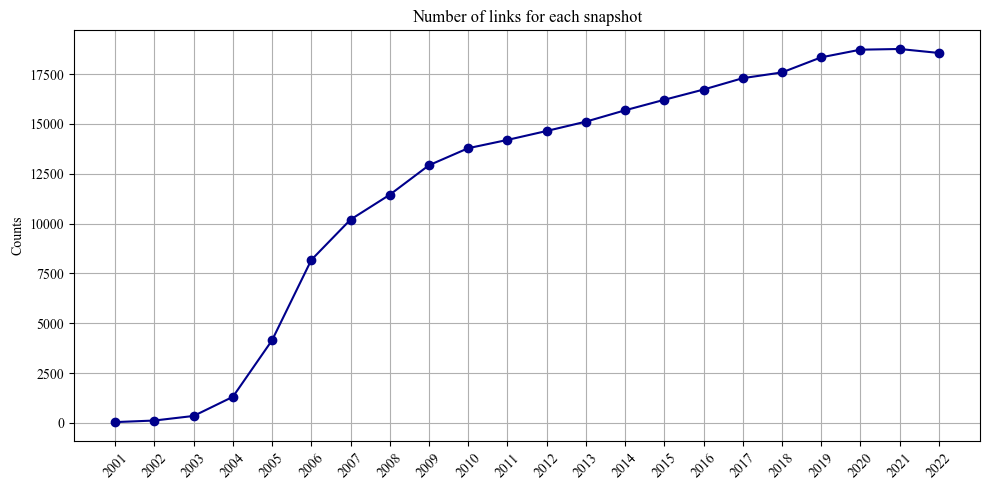

In [26]:
counts = edgelist.groupby("timestamp").size()
fig, ax = plt.subplots(figsize=(10,5), dpi=100)
ax.plot(counts.index.astype(str), counts.values, '-o', c='darkblue')
ax.set_title("Number of links for each snapshot")
ax.set_ylabel("Counts")
#ax.set_yscale("log")
ax.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

As seen in the above figure, the total number of links each year appears to demonstrate a nearly exponential growth within the initial period of 2001 to 2006, followed by a somewhat linear growth which may begin to plateau in the year 2022. Furthermore, the exponential trend present between 2001 and 2006 aligns with the trend of the growth w.r.t the number of nodes presented in the figures above. The linear increase in the number of edges after 2006 deviates from the trend associated with the growth of nodes. The number of nodes appears to stagnate after 2006, which intuitively makes sense given that set of superheroes used to generate the network was finite and consisted of a little more than 2000 superheroes, while the edges among Wikipedia is less constrained and only strictly restricted by the total number of possible edges in a directed network:
$$N*(N-1)\approx 2000*(2000-1) \approx 4,000,000$$

However, it is important to mention that the number of links in the observed network is significantly less than the possible number of links. This indicates the sparsity of the network, which is also a common characteristic associated with real networks.


In [27]:
temp = pd.merge(edgelist, df, left_on='source', right_on='WikiLink')
temp = temp.rename(columns={"universe":"source universe"})
temp = temp.drop(columns=['CharacterName', 'WikiLink'])
temp = pd.merge(temp, df, left_on='target', right_on='WikiLink')
temp = temp.rename(columns={"universe":"target universe"})
temp = temp.drop(columns=['CharacterName', 'WikiLink'])
expanded_edgelist = temp.copy()

Furthermore, to investigate how many links DC and Marvel have respectively. The number of edges within each of the two comics universes was illustrated along with the number of edges across the two. Hence, the following figure demonstrates the intra and inter universe links:

In [28]:
count_df = expanded_edgelist.groupby(["timestamp","source universe", "target universe"]).size().reset_index(name="counts")
dc_links = []
marvel_links = []
marvel_dc_links = []
dc_marvel_links = []
for idx, row in count_df.iterrows():
    if row["source universe"] == "DC" and row["target universe"] == "DC":
        dc_links.append(row.counts)
    elif row["source universe"] == "Marvel" and row["target universe"] == "Marvel":
        marvel_links.append(row.counts)
    elif row["source universe"] == "Marvel" and row["target universe"] == "DC":
        marvel_dc_links.append(row.counts)
    else:
        dc_marvel_links.append(row.counts)
marvel_dc_links.insert(0, 0)#No inter connected at year 2001

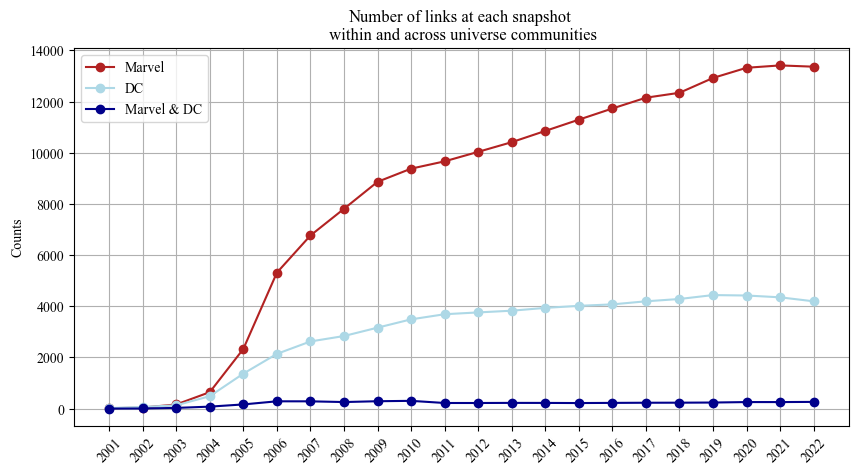

In [29]:
fig, ax = plt.subplots(figsize=(10,5), dpi=100)

ax.plot(count_df.timestamp.astype(str).unique(), marvel_links, '-o', c='firebrick',label="Marvel")
ax.plot(count_df.timestamp.astype(str).unique(), dc_links, '-o', c='lightblue',label="DC")
ax.plot(count_df.timestamp.astype(str).unique(), marvel_dc_links, '-o', c='darkblue',label="Marvel & DC")
ax.set_ylabel("Counts")
ax.legend()
ax.set_title("Number of links at each snapshot \n within and across universe communities")
ax.grid()
plt.xticks(rotation=45)
plt.show()

The illustration of the number of links within and across the two universes demonstrates that the Marvel universe contains a significantly greater number of links compared with the DC universe. Interestingly, the number of links between the two universes seems to be almost negligible throughout the entire timespan, which indicates that two universes coexist within the superhero network as almost two disconnected communities compared with the number of edges within the two universes.

### Degree Distribution Analysis
Let's first view the average degree of nodes in the graph at each timestep to determine if this follows the same trend as the edge analysis:

In [30]:
#create edgelist for each year
import networkx as nx
import numpy as np
edgelist_divided = {}
groups = edgelist.groupby('timestamp').groups
for key, index in groups.items():
    edgelist_divided[key] = edgelist.loc[index]

In [31]:
#we will load in the graph from a list of gml files
#as setting node attributes takes a while 
#(and does not look pretty)
graphs = {}
for key in np.arange(2001,2023,1):
    graphs[key] = nx.read_gml(f'graphs/DG_{key}')

In [32]:
#Calculate degrees
avg_degrees = {}
for key in graphs.keys():
    avg_degrees[key] = sum([graphs[key].in_degree(x) for x in graphs[key].nodes()])/graphs[key].number_of_nodes()

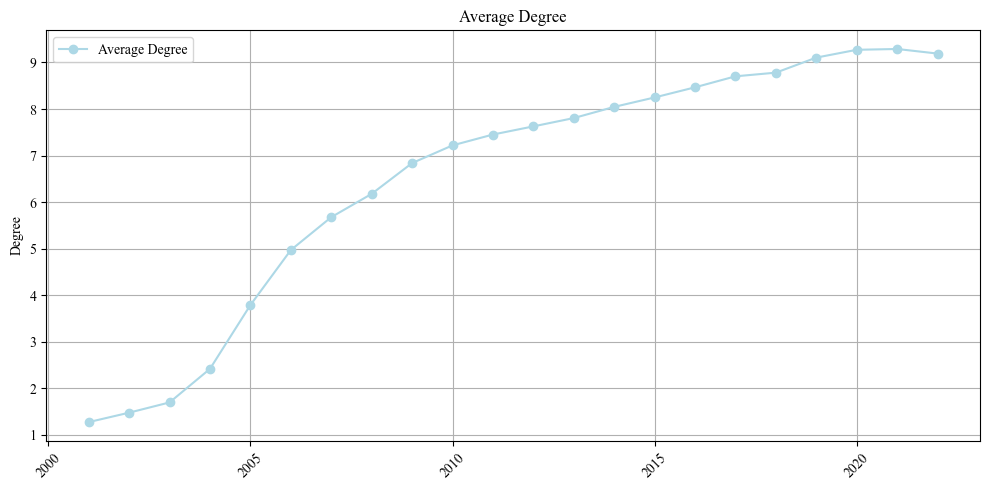

In [33]:
fig, ax = plt.subplots(figsize=(10,5), dpi=100)
ax.plot(list(avg_degrees.keys()), list(avg_degrees.values()), '-o', c='lightblue', label='Average Degree')
ax.set_title("Average Degree")
ax.set_ylabel("Degree")
ax.grid()
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

It follows the exact same trend as the number of edges as expected because the average degree of a directed network is defined as the total number of links divided by the total number of nodes [3]:
$$\langle k\rangle=\frac{L}{N}$$

#### Static Analysis of Degree Distributions

To attempt to understand the characteristics of the temporal network, we analyse the degree distribution. Initially, the analysis of the degree distribution of the temporal network will be restricted to the final time step $t_{N}$ and treated as a static network. Subsequently, we will analyse the degree distribution at each timestep to investigate if any changes emerge in the network characteristics as time passes.

In [34]:
years = sorted(expanded_edgelist.timestamp.unique())
tN = years[-1]
edgelist_tN = expanded_edgelist[expanded_edgelist.timestamp==tN]
attrs_tN = {row.source: {'group': row['source universe']} for idx, row in edgelist_tN.iterrows()}
G_tN = nx.from_pandas_edgelist(edgelist_tN, create_using = nx.DiGraph)
#Adding attributes
nx.set_node_attributes(G_tN, attrs_tN)
#Fixing issue with nodes missing universe data
missing_attrs = {row.target: {'group': row['target universe']}for idx, row in edgelist_tN[edgelist_tN['target'].isin([u for u,v in G_tN.nodes(data=True) if not v])].iterrows()}
nx.set_node_attributes(G_tN, missing_attrs)
#Removing singleton nodes
G_tN.remove_nodes_from(list(nx.isolates(G_tN)))

The following figures illustrate the in-degree and out-degree distribution using a linear binning and linear x- and y-scale:

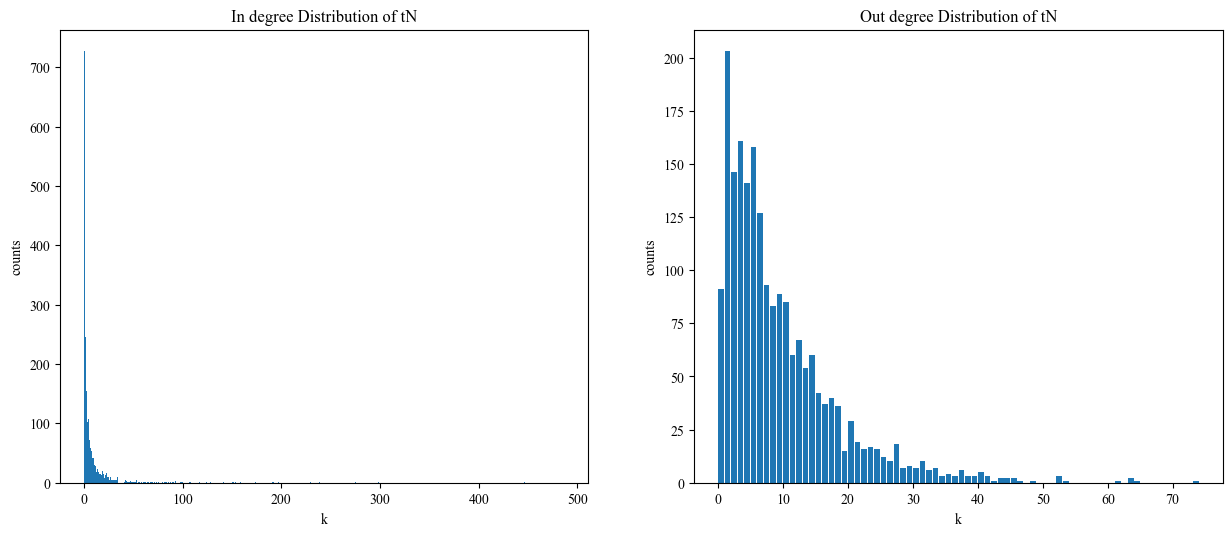

In [35]:
in_degrees = [y for (x,y) in G_tN.in_degree]
out_degrees = [y for (x,y) in G_tN.out_degree]

bins = np.arange(min(in_degrees), max(in_degrees), 1)
hist, edges = np.histogram(in_degrees, bins=bins)
x = (edges[1:] + edges[:-1])/2
width = bins[1]-bins[0]

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,6), dpi=100)
ax1.bar(x, hist, width=width*0.91)
ax1.set_ylabel("counts")
ax1.set_xlabel("k")
ax1.set_title("In degree Distribution of tN")

bins = np.arange(min(out_degrees), max(out_degrees), 1)
hist, edges = np.histogram(out_degrees, bins=bins)
x = (edges[1:] + edges[:-1])/2
width = bins[1]-bins[0]
ax2.bar(x, hist, width=width*0.90)
ax2.set_ylabel("counts")
ax2.set_xlabel("k")
ax2.set_title("Out degree Distribution of tN")
plt.show()

The main finding in the above figures is the apparent difference between the characteristics of the in-degree and out-degree distributions. The out-degree distribution resembles a Poisson distribution, which typically is associated with the degree distribution of a random network. However, the in-degree distribution appears to follow a heavy-tailed power-law distribution often associated with scale-free networks. To further investigate if the two degree distributions follow the distributions proposed above, the in-degree and out-degree distributions are illustrated using a logarithmic binning and a logarithmic x- and y-scale. If the in-degree distribution follows a power-law distribution, the degree distribution should fall on a straight line when using a logarithmic scale:

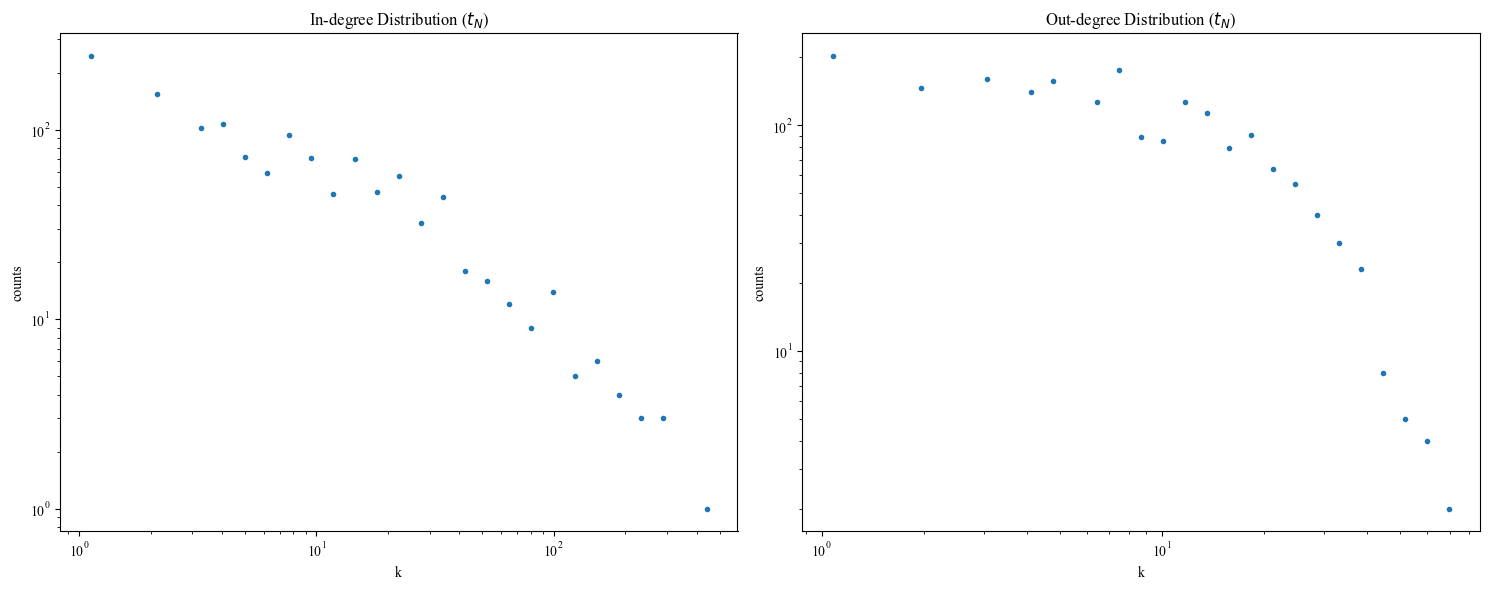

In [36]:
in_degrees = [d for n, d in G_tN.in_degree()]
min_in_deg =min(in_degrees)
max_in_deg =max(in_degrees)
min(in_degrees), max(in_degrees)

#bins = np.arange(min_in_deg, max_in_deg, 1) #Linear binning
bins = np.logspace(0, np.log10(max_in_deg), 30) # log binning
in_hist, in_edges = np.histogram(in_degrees, bins=bins)
in_x = (in_edges[1:]+in_edges[:-1])/2


out_degrees = [d for n, d in G_tN.out_degree()]
min_out_deg =min(out_degrees)
max_out_deg =max(out_degrees)
min(out_degrees), max(out_degrees)

#bins = np.arange(min_out_deg, max_out_deg, 1) #Linear binning
bins = np.logspace(0, np.log10(max_out_deg), 30) # log binning
out_hist, out_edges = np.histogram(out_degrees, bins=bins)
out_x = (out_edges[1:]+out_edges[:-1])/2

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,6), dpi=100)

in_xx, in_yy = zip(*[(i,j) for (i,j) in zip(in_x, in_hist) if j > 0])
ax1.plot(in_xx, in_yy, marker='.', linestyle='None')
ax1.set_ylabel("counts")
ax1.set_xlabel("k")
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_title("In-degree Distribution ($t_{N}$)")

out_xx, out_yy = zip(*[(i,j) for (i,j) in zip(out_x, out_hist) if j > 0])
ax2.plot(out_xx, out_yy, marker='.', linestyle='None')
ax2.set_ylabel("counts")
ax2.set_xlabel("k")
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_title("Out-degree Distribution ($t_{N}$)")
plt.tight_layout()
plt.show()

In-degree distributions of the network at $t_{N}$ appear to follow a scale-free network structure, while the out-degree distribution resembles the degree distribution of a random network. Intuitively, this finding makes sense given that the in-degree reflects the number of Wikipedia pages that reference this specific page, while the out-degree reflects how many other Wikipedia pages this given page references. Naturally, the out-degree will be more constrained than the in-degree, given that there is a naturally occurring limit to how many references one can gather on a single Wikipedia page. The in-degree is less constrained and somewhat reflects the popularity of a single page. A similar phenomenon can be seen in follower-based social media platforms e.g. Twitter, where it seems that the number of followers a person might have is almost unconstrained except for the number of users of the platform ([e.g. Justin Bieber having 113.8 million followers on Twitter](https://en.wikipedia.org/wiki/List_of_most-followed_Twitter_accounts)), while the number of individuals a person might follow is limited by the cognitive demand of keeping up with all the content these individuals produce. The fact that the In-degree distribution is heavy-tailed and resembles a power law implies that the network contains hubs, which are Wikipedia pages being referenced by other Wikipedia pages much more than average.

#### Temporal Analysis of Degree Distributions
Additionally, the in-degree and out-degree distributions are determined at each yearly snapshot of the temporal network to gain insight into how the degree distributions have changed with time. The degree distributions are plotted along side each other using a logarithmic binning and scale:

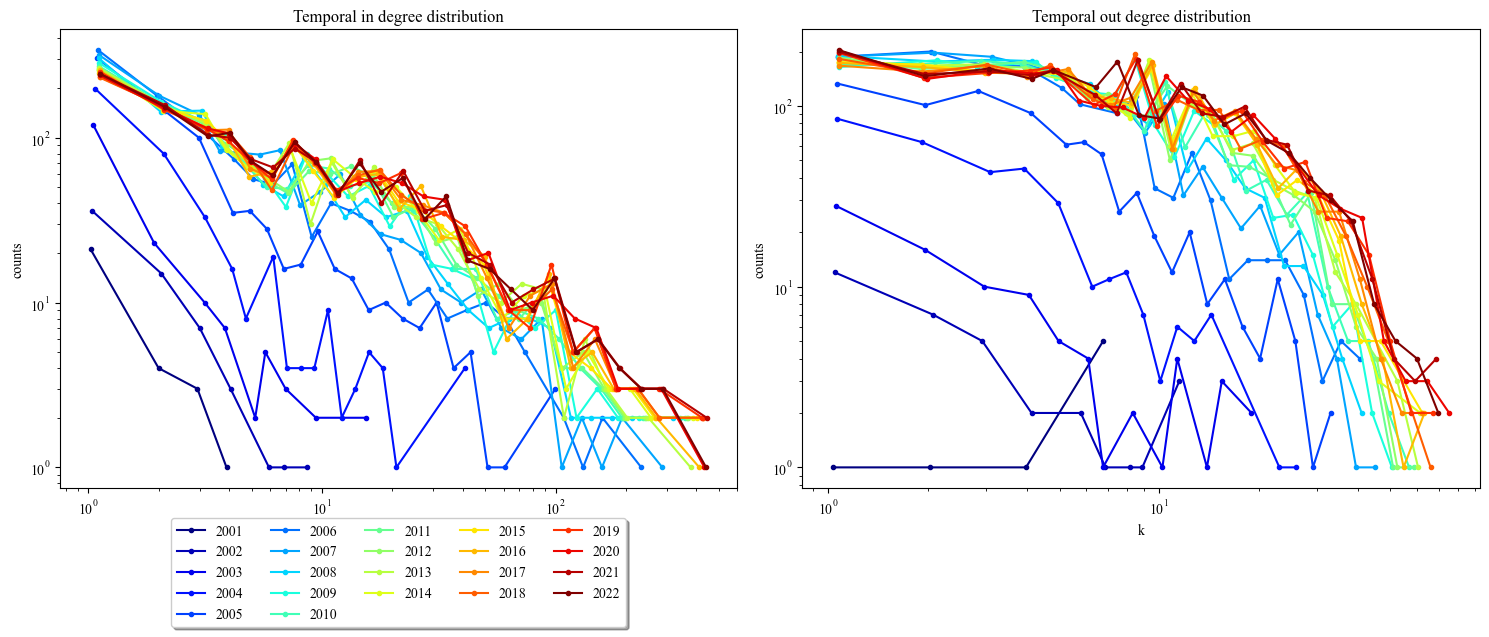

In [37]:
import matplotlib.pylab as pl
import networkx as nx

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,6), dpi=100)

years = sorted([x for x in expanded_edgelist.timestamp.unique()])
n = len(years)
#colors = pl.cm.plasma(np.linspace(0,1,n))
colors = pl.cm.jet(np.linspace(0,1,n))
for idx, year in enumerate(years):
    edgelist_temp = expanded_edgelist[expanded_edgelist.timestamp == year]
    G_temp = nx.from_pandas_edgelist(edgelist_temp, create_using = nx.DiGraph)

    #Removing singleton nodes
    G_temp.remove_nodes_from(list(nx.isolates(G_temp)))

    in_degrees = [d for n, d in G_temp.in_degree()]
    min_in_deg =min(in_degrees)
    max_in_deg =max(in_degrees)
    
    #bins = np.arange(min_in_deg, max_in_deg, 1)
    bins = np.logspace(0, np.log10(max_in_deg), 30) # log binning
    in_hist, in_edges = np.histogram(in_degrees, bins=bins)
    in_x = (in_edges[1:]+in_edges[:-1])/2


    out_degrees = [d for n, d in G_temp.out_degree()]
    min_out_deg =min(out_degrees)
    max_out_deg =max(out_degrees)

    #bins = np.arange(min_out_deg, max_out_deg, 1) #Linear binning
    bins = np.logspace(0, np.log10(max_out_deg), 30) # log binning
    out_hist, out_edges = np.histogram(out_degrees, bins=bins)
    out_x = (out_edges[1:]+out_edges[:-1])/2
    
    in_xx, in_yy = zip(*[(i,j) for (i,j) in zip(in_x, in_hist) if j > 0])
    ax1.plot(in_xx, in_yy, marker='.', c=colors[idx], label=str(year))
    ax1.set_ylabel("counts")
    ax1.set_xlabel("k")
    ax1.set_xscale("log")
    ax1.set_yscale("log")
    ax1.set_title("Temporal in degree distribution")

    out_xx, out_yy = zip(*[(i,j) for (i,j) in zip(out_x, out_hist) if j > 0])
    ax2.plot(out_xx, out_yy, marker='.', c=colors[idx], label=str(year))
    ax2.set_ylabel("counts")
    ax2.set_xlabel("k")
    ax2.set_xscale("log")
    ax2.set_yscale("log")
    ax2.set_title("Temporal out degree distribution")
box = ax1.get_position()
ax1.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)

plt.tight_layout()
plt.show()

The figures illustrate that the temporal in-degree distribution converges into a degree distribution that resembles a power-law distribution. The temporal out-degree distribution also demonstrates that it converges into a distribution similar to a Poisson distribution when time passes. Furthermore, the figures indicate that the stability in the degree distributions increases, given that the yearly difference in degree distributions appear to decrease with time. 

### Investigation of selected superheros

#### Captain America

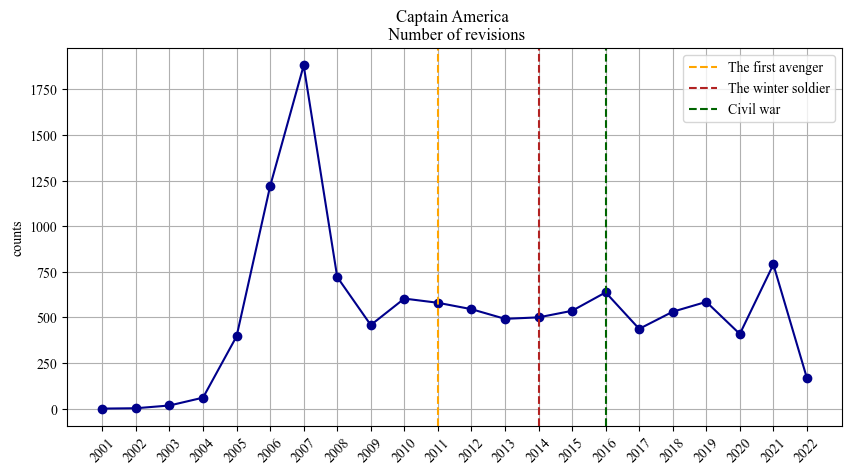

In [38]:
with open(path_folder + 'Captain America'+ '/' + 'number_of_revisions.pkl', 'rb') as handle:
    cap_revisions = pickle.load(handle)
fig, ax = plt.subplots(figsize=(10,5), dpi=100)
ax.plot([str(item) for item in list(cap_revisions.keys())], list(cap_revisions.values()), '-o', c='darkblue')
ax.grid()
plt.axvline(x="2011", linestyle='--',c='orange', label="The first avenger")
plt.axvline(x="2014", linestyle='--',c='firebrick', label="The winter soldier")
plt.axvline(x="2016", linestyle='--',c='darkgreen', label="Civil war")
ax.set_ylabel("counts")
ax.set_title("Captain America \n Number of revisions")
ax.legend()
plt.xticks(rotation=45)
plt.show()

It is interesting to see a very popular Marvel character like Captain America. He has many revisions at all times and other than Civil war, it doesn't look like movie release dates revolving about him creates spikes unlike Black Panther below.

#### Black Panther

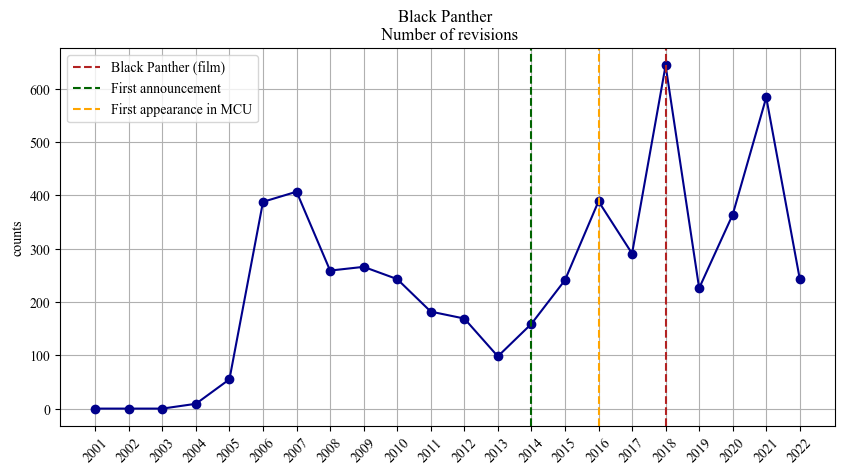

In [39]:
with open(path_folder + 'Black Panther'+ '/' + 'number_of_revisions.pkl', 'rb') as handle:
    black_panther_revisions = pickle.load(handle)
fig, ax = plt.subplots(figsize=(10,5), dpi=100)
ax.plot([str(item) for item in list(cap_revisions.keys())], list(black_panther_revisions.values()), '-o', c='darkblue')
ax.axvline(x="2018", linestyle='--',c='firebrick', label="Black Panther (film)")
ax.axvline(x="2014", linestyle='--', c='darkgreen', label="First announcement")
ax.axvline(x="2016", linestyle='--', c='orange', label="First appearance in MCU")
ax.grid()
ax.set_ylabel("counts")
ax.set_title("Black Panther \n Number of revisions")
ax.legend()
plt.xticks(rotation=45)
plt.show()

Here we see that appearance in the MCU and his own movie really introduces spikes.

In general, it seems that the introduction of less familiar characters introduces way more spikes in revisions as there is not a lot of stuff to write about untill they appear in movies or new comic books. Captain America has had his MCU story written a long time ago while Black Panther's is only getting written in later years.

What are the last spikes? In 2020 Chadwick Boseman (the actor) died and in 2021 a new comic book issue of Black Panther is released which was quite hyped.

# Does the Gender and Race of a Character Play a Role in the Network?
To answer this question, we will use the general permutation test framework, where the gender and race properties of the nodes will be randomly shuffled. Hence, creating an ensemble of networks with random node properties, which subsequently will be compared with the observed network. Using the permutation test framework one can easily compute the p-value to determine if there is a significant difference between the test statistic of the permuted and the observed networks.

The test statistic of interest in this investigation is the average node betweenness centrality w.r.t gender and race, respectively. The initial part will focus on gender followed by the race. Therefore, the question of interest is whether or not gender and race influence the centrality of a node in the network.

To determine the significance of e.g. gender, the following steps will be carried out:
1) Determine the average betweenness centrality of female and male characters, respectively. ($C_{female}$, $C_{male}$)
<br >

2) Conduct a thousand permutations of the nodes' gender property and calculate the average betweenness centrality for each permutation to obtain ($\{C_{female}(R_{1}), C_{female}(R_{2}),..., C_{female}(R_{1000}) \}$ & $\{C_{male}(R_{1}), C_{male}(R_{2}),..., C_{male}(R_{1000}) \}$)
<br >

3) Compute the p-value, which corresponds to the proportion of permuted test statistics that exceeds the observed test statistic.

We have decided to only conduct the one-sided permutation test. However, in some cases, we conduct two one-sided permutation tests to test if the test statistic is significantly higher or lower.


In [40]:
from tqdm import tqdm
import random

In [41]:
gender_map = {}
for idx, row in meta_df.iterrows():  
    if row['woman'] == 1:
        gender_map[row.WikiLink] = "Female"
    elif row['man'] == 1:
        gender_map[row.WikiLink] = "Male"
    else:
        gender_map[row.WikiLink] = "NaN"

Initially, the permutation test will investigate if the gender of a superhero play any significant role in the network in 2022 w.r.t node centrality.

In [42]:
N=1000
edgelist_temp = expanded_edgelist[expanded_edgelist.timestamp==2022]
attrs_temp = {row.source: {'group': gender_map[row.source]} for idx, row in edgelist_temp.iterrows()}
G_temp = nx.from_pandas_edgelist(edgelist_temp, create_using = nx.DiGraph)

#Adding attributes
nx.set_node_attributes(G_temp, attrs_temp)

#Fixing issue with nodes missing universe data
missing_attrs = {row.target: {'group': gender_map[row.target]}for idx, row in edgelist_temp[edgelist_temp['target'].isin([u for u,v in G_temp.nodes(data=True) if not v])].iterrows()}
nx.set_node_attributes(G_temp, missing_attrs)


#Removing singleton nodes
G_temp.remove_nodes_from(list(nx.isolates(G_temp)))

#Fetching universe of nodes
universe = nx.get_node_attributes(G_temp, "group")

centrality = nx.betweenness_centrality(G_temp)
true_centrality = {"Female": [], "Male":[], "NaN":[]}

#Adding true centrality means
for u,v in centrality.items():
    true_centrality[universe[u]].append(v)

true_mean_female = np.mean(true_centrality['Female'])
true_mean_male = np.mean(true_centrality['Male'])

random_female = []
random_male = []
#Conducting permutation tests
for _ in tqdm(range(N)):
    labels = list(nx.get_node_attributes(G_temp, "group").values())
    random_labels = np.random.permutation(labels)
    universe = dict(zip(G_temp.nodes(),random_labels))
    uni_centrality = {"Female": [], "Male":[], "NaN": []}
    for u,v in centrality.items():
        uni_centrality[universe[u]] += [v]

    random_female.append(np.mean(uni_centrality['Female']))
    random_male.append(np.mean(uni_centrality['Male']))

100%|██████████████████████████████████████| 1000/1000 [00:03<00:00, 286.37it/s]


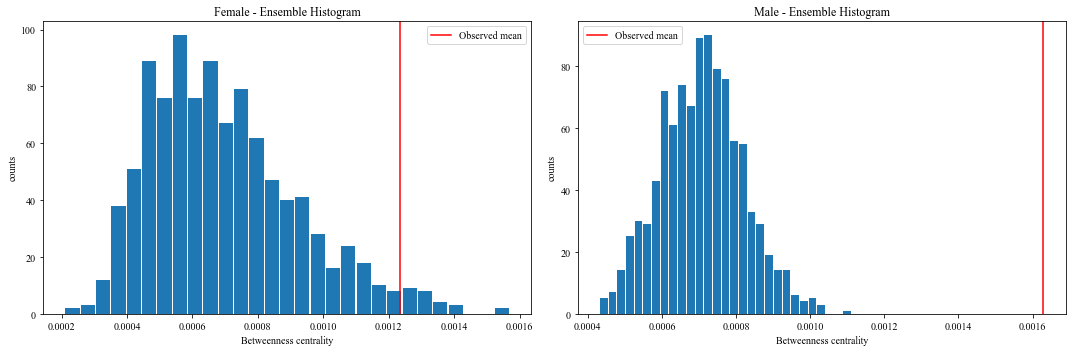

In [90]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))

bins_female = np.linspace(min(random_female), max(random_female), 30) # TODO: adjust binning
bins_male = np.linspace(min(random_male), max(random_male), 30)

hist_female, edges_female = np.histogram(random_female, bins=bins_female)
hist_male, edges_male = np.histogram(random_male, bins=bins_male)

x_female = (edges_female[1:]+edges_female[:-1])/2
x_male = (edges_male[1:]+edges_male[:-1])/2
width_female = edges_female[1] - edges_female[0]
width_male = edges_male[1] - edges_male[0]

ax1.bar(x_female, hist_female, width=width_female*0.93)
ax1.axvline(true_mean_female, c='r', label='Observed mean')
ax2.bar(x_male, hist_male, width= width_male*0.89)
ax2.axvline(true_mean_male, c='r', label='Observed mean')

ax1.set_title("Female - Ensemble Histogram")
ax2.set_title("Male - Ensemble Histogram")
ax1.set_xlabel("Betweenness centrality")
ax2.set_xlabel("Betweenness centrality")
ax1.set_ylabel("counts")
ax2.set_ylabel("counts")
ax1.legend()
ax2.legend()
plt.tight_layout()
plt.show()

In [44]:
pval_female = len([i for i in random_female if i  > true_mean_female])/N
pval_male = len([i for i in random_male if i > true_mean_male])/N
pval_female, pval_male

(0.028, 0.0)

Both of the tests yield a p-value belov the significance level $\alpha=0.05$. Hence, indicating that the gender of the superhero does have a significant influence on the centrality of the superhero. We do see that the betweenness centrality is larger for men than for women also, indicating that male superheroes are often more central in the graph than female ones. Is this true in other years as well!

### Temporal permutation test

Furthermore, to evaluate the influence of gender in the whole temporal network, the p-values were determined at each yearly snapshot of the network using the same approach as above.

In [45]:
years = sorted(expanded_edgelist.timestamp.unique())
true_means_female = []
true_means_male = []
pvals_female = []
pvals_male = []
pvals_nan = []
N = 1000


for year in tqdm(years):
    edgelist_temp = expanded_edgelist[expanded_edgelist.timestamp==year]
    #attrs_temp = {row.source: {'group': row['source universe']} for idx, row in edgelist_temp.iterrows()}
    attrs_temp = {row.source: {'group': gender_map[row.source]} for idx, row in edgelist_temp.iterrows()}
    G_temp = nx.from_pandas_edgelist(edgelist_temp, create_using = nx.DiGraph)

    #Adding attributes
    nx.set_node_attributes(G_temp, attrs_temp)

    #Fixing issue with nodes missing universe data
    missing_attrs = {row.target: {'group': gender_map[row.target]}for idx, row in edgelist_temp[edgelist_temp['target'].isin([u for u,v in G_temp.nodes(data=True) if not v])].iterrows()}
    nx.set_node_attributes(G_temp, missing_attrs)


    #Removing singleton nodes
    G_temp.remove_nodes_from(list(nx.isolates(G_temp)))

    #Fetching universe of nodes
    universe = nx.get_node_attributes(G_temp, "group")

    centrality = nx.betweenness_centrality(G_temp)
    true_centrality = {"Female": [], "Male":[], "NaN":[]}

    #Adding true centrality means
    for u,v in centrality.items():
        true_centrality[universe[u]].append(v)

    true_mean_female = np.mean(true_centrality['Female'])
    true_mean_male = np.mean(true_centrality['Male'])
    true_mean_nan = np.mean(true_centrality['NaN'])

    random_female = []
    random_male = []
    random_nan = []
    #Conducting permutation tests
    for _ in range(N):
        labels = list(nx.get_node_attributes(G_temp, "group").values())
        random_labels = np.random.permutation(labels)
        universe = dict(zip(G_temp.nodes(),random_labels))
        uni_centrality = {"Female": [], "Male":[], "NaN": []}
        for u,v in centrality.items():
            uni_centrality[universe[u]] += [v]

        random_female.append(np.mean(uni_centrality['Female']))
        random_male.append(np.mean(uni_centrality['Male']))
        random_nan.append(np.mean(uni_centrality['NaN']))

    #Computing pvals
    pval_female = len([i for i in random_female if i  >= true_mean_female])/N
    pval_male = len([i for i in random_male if i >= true_mean_male])/N
    pval_nan = len([i for i in random_nan if i >= true_mean_nan])/N
    
    pvals_female.append(pval_female)
    pvals_male.append(pval_male)
    pvals_nan.append(pval_nan)
    

100%|███████████████████████████████████████████| 22/22 [04:53<00:00, 13.34s/it]


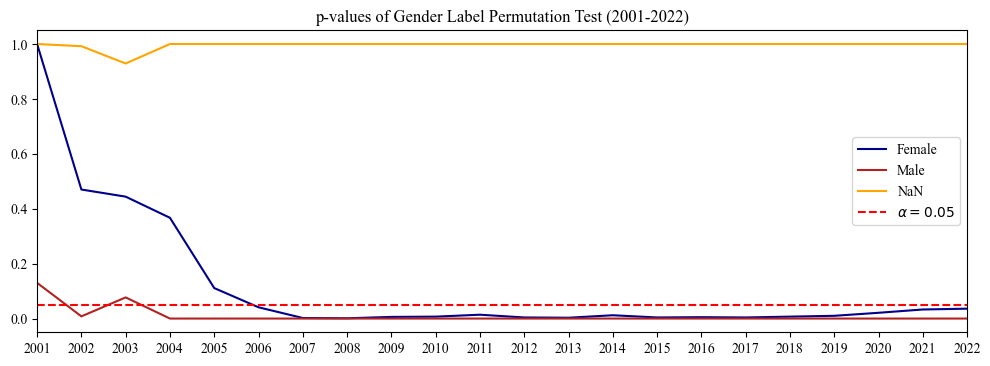

In [46]:
fig, ax = plt.subplots(figsize=(12,4), dpi=100)
ax.plot([str(year) for year in years], pvals_female, label='Female', c='darkblue')
ax.plot([str(year) for year in years], pvals_male, label='Male', c='firebrick')
ax.plot([str(year) for year in years], pvals_nan, label='NaN', c='orange')
ax.axhline(0.05, c='r', linestyle='--', label=r"$\alpha=0.05$")
ax.set_xlim(['2001','2022'])
ax.legend()
ax.set_title("p-values of Gender Label Permutation Test (2001-2022)")
plt.show()

We see here that the betweenness centrality of males is significantly different from that of a graph with random labels every year apart from 2003. Females' betweenness centrality is only significant after 2006.

Well, what does this mean? It means that the average betweenness centrality of females was only significantly higher than the average betweenness centrality of the networks with permuted gender labels after 2006, which implies that the node property female had no significant influence on node centrality before 2006.

We can, however, compare it to the unlabeled data. It is never significantly higher than a graph with permuted labels, which can be because the betweenness score is lower for unlabeled data; we tend to have metadata on popular nodes with high betweenness centrality and not on less popular ones. We can investigate this by doing a one-sided permutation test from the other side - checking the significance that the centrality of unlabeled data is lower than that of randomly permuted labels!


In [47]:
years = sorted(expanded_edgelist.timestamp.unique())
true_means_female = []
true_means_male = []
pvals_female = []
pvals_male = []
pvals_nan = []
N = 1000


for year in tqdm(years):
    edgelist_temp = expanded_edgelist[expanded_edgelist.timestamp==year]
    #attrs_temp = {row.source: {'group': row['source universe']} for idx, row in edgelist_temp.iterrows()}
    attrs_temp = {row.source: {'group': gender_map[row.source]} for idx, row in edgelist_temp.iterrows()}
    G_temp = nx.from_pandas_edgelist(edgelist_temp, create_using = nx.DiGraph)

    #Adding attributes
    nx.set_node_attributes(G_temp, attrs_temp)

    #Fixing issue with nodes missing universe data
    missing_attrs = {row.target: {'group': gender_map[row.target]}for idx, row in edgelist_temp[edgelist_temp['target'].isin([u for u,v in G_temp.nodes(data=True) if not v])].iterrows()}
    nx.set_node_attributes(G_temp, missing_attrs)


    #Removing singleton nodes
    G_temp.remove_nodes_from(list(nx.isolates(G_temp)))

    #Fetching universe of nodes
    universe = nx.get_node_attributes(G_temp, "group")

    centrality = nx.betweenness_centrality(G_temp)
    true_centrality = {"Female": [], "Male":[], "NaN":[]}

    #Adding true centrality means
    for u,v in centrality.items():
        true_centrality[universe[u]].append(v)

    true_mean_female = np.mean(true_centrality['Female'])
    true_mean_male = np.mean(true_centrality['Male'])
    true_mean_nan = np.mean(true_centrality['NaN'])

    random_female = []
    random_male = []
    random_nan = []
    #Conducting permutation tests
    for _ in range(N):
        labels = list(nx.get_node_attributes(G_temp, "group").values())
        random_labels = np.random.permutation(labels)
        universe = dict(zip(G_temp.nodes(),random_labels))
        uni_centrality = {"Female": [], "Male":[], "NaN": []}
        for u,v in centrality.items():
            uni_centrality[universe[u]] += [v]

        random_female.append(np.mean(uni_centrality['Female']))
        random_male.append(np.mean(uni_centrality['Male']))
        random_nan.append(np.mean(uni_centrality['NaN']))

    #Computing pvals
    pval_female = len([i for i in random_female if i  <= true_mean_female])/N
    pval_male = len([i for i in random_male if i <= true_mean_male])/N
    pval_nan = len([i for i in random_nan if i <= true_mean_nan])/N
    
    pvals_female.append(pval_female)
    pvals_male.append(pval_male)
    pvals_nan.append(pval_nan)
    

100%|███████████████████████████████████████████| 22/22 [05:00<00:00, 13.65s/it]


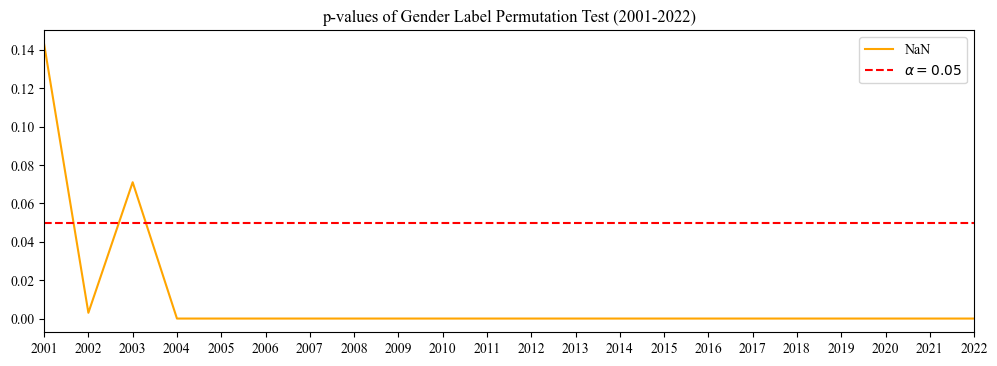

In [48]:
fig, ax = plt.subplots(figsize=(12,4), dpi=100)
#ax.plot([str(year) for year in years], pvals_female, label='Female', c='darkblue')
#ax.plot([str(year) for year in years], pvals_male, label='Male', c='firebrick')
ax.plot([str(year) for year in years], pvals_nan, label='NaN', c='orange')
ax.axhline(0.05, c='r', linestyle='--', label=r"$\alpha=0.05$")
ax.set_xlim(['2001','2022'])
ax.legend()
ax.set_title("p-values of Gender Label Permutation Test (2001-2022)")
plt.show()

We see that unlabeled data do indeed tend to have a lower centrality than randomly permuted labels! This is a clear bias in our meta data.

This trend should not be the same in race as we do not have data on quite a few popular nodes (eg. Thor, Batman, Superman). Let's check it!

In [49]:
years = sorted(expanded_edgelist.timestamp.unique())
true_means_latino = []
true_means_black = []
pvals_latino = []
pvals_black = []
pvals_asian = []
pvals_nan = []
pvals_nan_under = []
N = 1000

race_map = {}
for idx, row in meta_df.iterrows():  
    if row['black'] == 1:
        gender_map[row.WikiLink] = "black"
    elif row['asian'] == 1:
        gender_map[row.WikiLink] = "asian"
    elif row['latino'] == 1:
        gender_map[row.WikiLink] = "latino"
    else:
        gender_map[row.WikiLink] = "NaN"

for year in tqdm(years):
    edgelist_temp = expanded_edgelist[expanded_edgelist.timestamp==year]
    #attrs_temp = {row.source: {'group': row['source universe']} for idx, row in edgelist_temp.iterrows()}
    attrs_temp = {row.source: {'group': gender_map[row.source]} for idx, row in edgelist_temp.iterrows()}
    G_temp = nx.from_pandas_edgelist(edgelist_temp, create_using = nx.DiGraph)

    #Adding attributes
    nx.set_node_attributes(G_temp, attrs_temp)

    #Fixing issue with nodes missing universe data
    missing_attrs = {row.target: {'group': gender_map[row.target]}for idx, row in edgelist_temp[edgelist_temp['target'].isin([u for u,v in G_temp.nodes(data=True) if not v])].iterrows()}
    nx.set_node_attributes(G_temp, missing_attrs)


    #Removing singleton nodes
    G_temp.remove_nodes_from(list(nx.isolates(G_temp)))

    #Fetching universe of nodes
    universe = nx.get_node_attributes(G_temp, "group")

    centrality = nx.betweenness_centrality(G_temp)
    true_centrality = {"latino": [], "black":[],"asian":[], "NaN":[]}

    #Adding true centrality means
    for u,v in centrality.items():
        true_centrality[universe[u]].append(v)

    true_mean_latino = np.mean(true_centrality['latino'])
    true_mean_black = np.mean(true_centrality['black'])
    true_mean_asian = np.mean(true_centrality['asian'])
    true_mean_nan = np.mean(true_centrality['NaN'])

    random_latino = []
    random_black = []
    random_asian = []
    random_nan = []
    #Conducting permutation tests
    for _ in range(N):
        labels = list(nx.get_node_attributes(G_temp, "group").values())
        random_labels = np.random.permutation(labels)
        universe = dict(zip(G_temp.nodes(),random_labels))
        uni_centrality = {"latino": [], "black":[],"asian":[], "NaN": []}
        for u,v in centrality.items():
            uni_centrality[universe[u]] += [v]

        random_latino.append(np.mean(uni_centrality['latino']))
        random_black.append(np.mean(uni_centrality['black']))
        random_asian.append(np.mean(uni_centrality['asian']))
        random_nan.append(np.mean(uni_centrality['NaN']))

    #Computing pvals
    pval_latino = len([i for i in random_latino if i  >= true_mean_latino])/N
    pval_black = len([i for i in random_black if i >= true_mean_black])/N
    pval_asian = len([i for i in random_asian if i >= true_mean_asian])/N
    pval_nan = len([i for i in random_nan if i >= true_mean_nan])/N
    pval_nan_under = len([i for i in random_nan if i <= true_mean_nan])/N
    
    pvals_latino.append(pval_latino)
    pvals_black.append(pval_black)
    pvals_asian.append(pval_asian)
    pvals_nan_under.append(pval_nan_under)
    pvals_nan.append(pval_nan)
    

  0%|                                                    | 0/22 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|███████████████████████████████████████████| 22/22 [04:49<00:00, 13.15s/it]


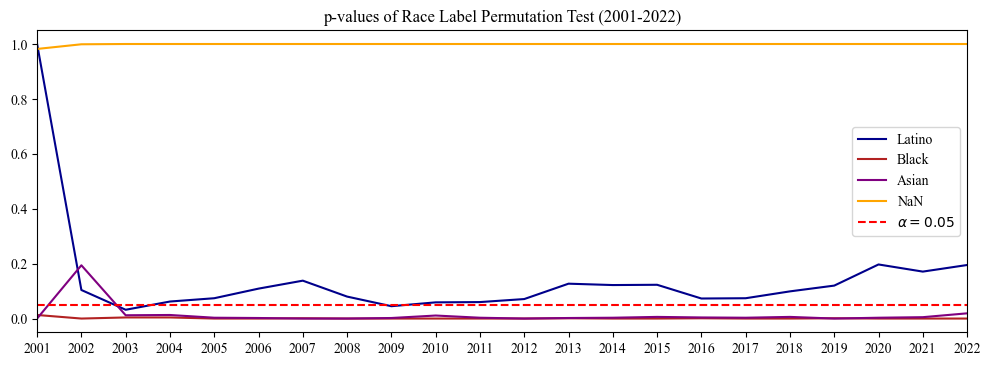

In [50]:
fig, ax = plt.subplots(figsize=(12,4), dpi=100)
ax.plot([str(year) for year in years], pvals_latino, label='Latino', c='darkblue')
ax.plot([str(year) for year in years], pvals_black, label='Black', c='firebrick')
ax.plot([str(year) for year in years], pvals_asian, label='Asian', c='purple')
ax.plot([str(year) for year in years], pvals_nan, label='NaN', c='orange')
ax.axhline(0.05, c='r', linestyle='--', label=r"$\alpha=0.05$")
ax.set_xlim(['2001','2022'])
ax.legend()
ax.set_title("p-values of Race Label Permutation Test (2001-2022)")
plt.show()

This is interesting. Black and Asian labels seem to have a significantly higher node centrality than random labels. Latino generally does not. This suggests that most Latino characters are not as central to the universes as blacks and asians.

It also seems that NaN is actually significant here as well. Apparently the same bias seems to be in place here as with gender; we only have meta data for popular superheroes.

Let's check the plot for NaN centrality to be under random centrality;

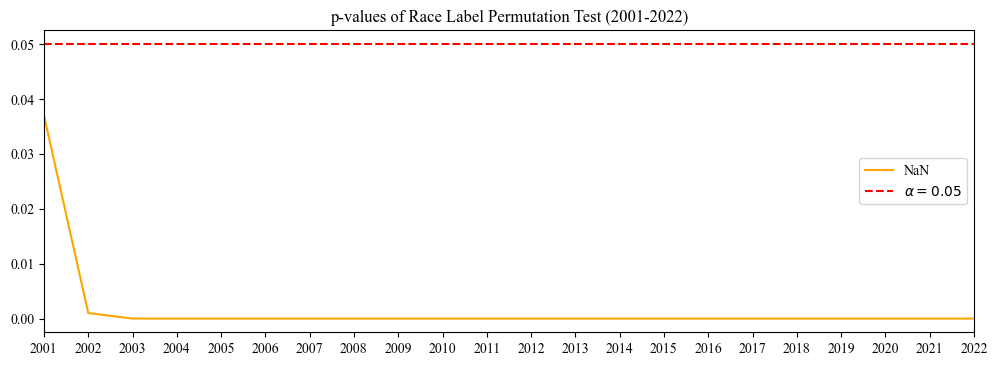

In [51]:
fig, ax = plt.subplots(figsize=(12,4), dpi=100)
ax.plot([str(year) for year in years], pvals_nan_under, label='NaN', c='orange')
ax.axhline(0.05, c='r', linestyle='--', label=r"$\alpha=0.05$")
ax.set_xlim(['2001','2022'])
ax.legend()
ax.set_title("p-values of Race Label Permutation Test (2001-2022)")
plt.show()

NaN centrality is significantly lower than random. When creating our meta data we found something weird; most superheroes have a black or asian version. This was true for Batman and Superman at least. The links to these superheroes were not equal to the links that we had in our data however. This was because they linked to specific subsections in the Wiki pages where the superhero might have been of another race.

Therefore, we measured document similarity using shingles of the links and jaccard similarity between them. Only shingles that were 90% or more similar were given the attribute. So sometimes a very popular superhero that is mostly white (eg. Batman or Superman) might be given the attribute of a racial minority.

Because we would expect most superheroes that are white to have a high betweenness centrality, we would expect the yellow line above to be insignificant. However, if many high-betweenness-superheroes slipped through the jaccard similarity measure to be a minority this actually flaws our data.

So one of three things could have happened:

>1. Many very central white superheroes have gotten misclassified
>2. The bias that most popular superheroes are given a label is very strong in this situation.
>3. We are wrong about white superheroes generally having a higher betweenness centrality.


Although the third option might entail some interesting discussions we can almost certainly rule that out because other studies have shown that there are many more white superheroes that are essential to movies and comics.

The second option could still be true, however, we would still have more than a few highly central nodes that were left out and would give the non-labeled nodes a much higher average centrality.

Therefore, it could be a combination of the first and second option that explains this behaviour. This means that we can probably not really say anything about the two plots above. Maybe we will investigate this in the project.

## Centrality Evolution

The previous section attempted to investigate how the different attributes of the superheroes influence the centrality of the corresponding nodes. To further investigate the temporal evolution of the network, we will investigate the stability of nodes' eigenvector centrality as a function of time using the Pearson correlation. More specifically, the Pearson correlation between the eigenvector centrality of nodes at a given time step and the remaining time steps will be determined [2].

A subset of nodes that are continuously present throughout the time interval has to be found to compute the Pearson correlation correctly. Given that the majority of the nodes are present in the year 2007, the investigation will be limited to the period 2007 to 2022. The computed Pearson correlations are illustrated using a heatmap with years on the x- and y-axis such that the off-diagonal elements correspond to the estimated correlation between the node centralities from two different years.

In [52]:
import seaborn as sns

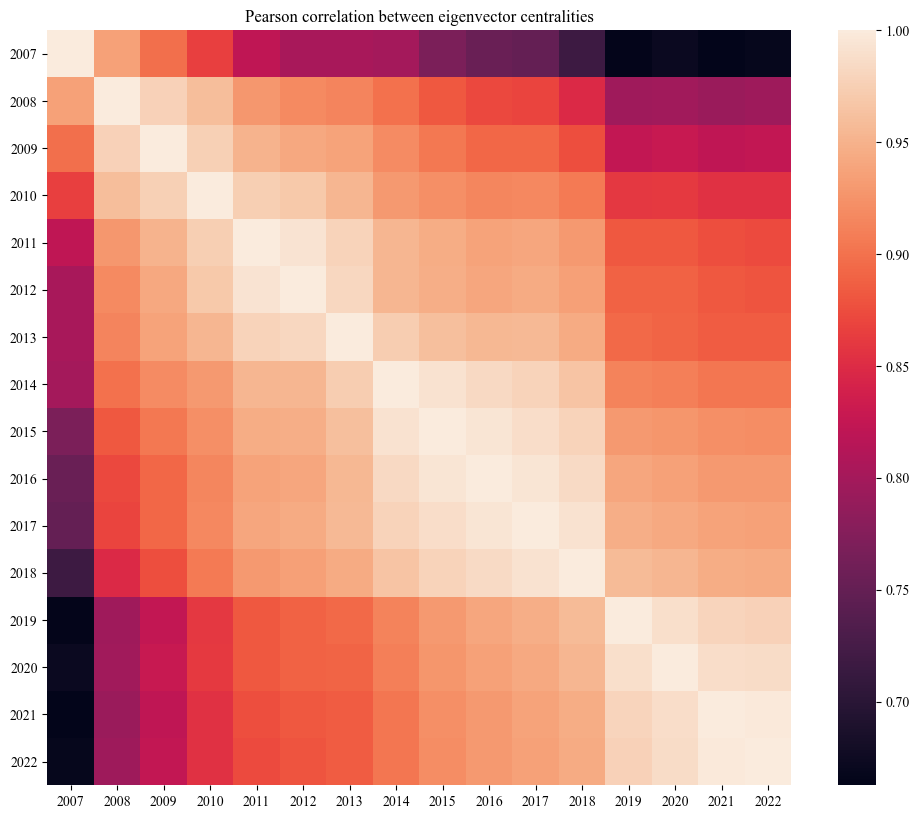

In [53]:
edgelist_2007 = edgelist[edgelist.timestamp==2007]
G_2007 = nx.from_pandas_edgelist(edgelist_2007, create_using=nx.DiGraph)
nodes = list(G_2007.nodes())

edgelist_2022 = edgelist[edgelist.timestamp==2022]
G_2022 = nx.from_pandas_edgelist(edgelist_2022, create_using=nx.DiGraph)
nodes_2022 = list(G_2022.nodes())

temp_list = []
for year in years[6:]:
    edgelist_temp = expanded_edgelist[expanded_edgelist.timestamp==year]
    G_temp = nx.from_pandas_edgelist(edgelist_temp, create_using=nx.DiGraph)
    temp_list.append(list(G_temp.nodes))

nodes_final = list(set(temp_list[0]) & set(temp_list[1]) 
    & set(temp_list[2]) & set(temp_list[3])
    & set(temp_list[4]) & set(temp_list[5])
    & set(temp_list[6]) & set(temp_list[7])
    & set(temp_list[8]) & set(temp_list[9])
    & set(temp_list[10]) & set(temp_list[11])
    & set(temp_list[12]) & set(temp_list[13])
    & set(temp_list[14]) & set(temp_list[15]))

eigenvals_centrality = np.zeros((len(nodes_final), len(temp_list)))
for idx, year in enumerate(years[6:]):
    edgelist_temp = expanded_edgelist[expanded_edgelist.timestamp==year]
    G_temp = nx.from_pandas_edgelist(edgelist_temp, create_using=nx.DiGraph)
    centrality_dict = nx.eigenvector_centrality(G_temp)
    #Getting nodes of interest
    eigenvals_centrality[:,idx] = [centrality_dict[node] for node in nodes_final if node in list(G_temp.nodes())]

corr = np.corrcoef(eigenvals_centrality, rowvar=False)

fig, ax = plt.subplots(figsize=(12,10), dpi=100)
sns.heatmap(corr, xticklabels=years[6:], yticklabels=years[6:], ax=ax)
ax.set_title("Pearson correlation between eigenvector centralities")
ax.tick_params(axis='y', rotation=0)
plt.show()

The heatmap correlation demonstrates that the Pearson correlation between node centralities of two different years depends on the time difference between the two years. For instance, by looking at the node centralities determined from 2007 and comparing the computed Pearson correlations with the remaining years, it becomes evident that the correlation decreases with every year passing. The figure demonstrates a generally high correlation between the node centralities from consecutive years. Interestingly, the figure also illustrates emerging block structures near the diagonal increasing in size with time. This trend indicates that the stability of eigenvector centrality increases with time.

## Clusters! How Do They Evolve?
In this section, the first part will try to investigate the hypothesis:
> * The network grows in a "coral-growth" pattern. 
>  - This will be tested by running an InfoMap Ensemble algorithm to determine communities in the graph at $t_n$. Then we will create a heatmap showing when nodes are added to each community to see whether they are added in a coral pattern - meaning that nodes within the same community are added at the same time. Spoiler alert: We will try to find an even cooler way to show this during our project!

Subsequently, we will try to visualise how the greatest communities have evolved through time by illustrating the node migration between the greatest communities at each timestep. Hopefully, this will provide insights into answering the following questions:
> * Does the communities of the temporal network demonstrate common characteristics w.r.t community evolution [3]?
>  - Growth/Contraction
>  - Merging/Splitting
>  - Birth/death
> * How stable are the communities in the temporal Wikipedia network as a function of time?
> * What specific periods demonstrate significant rewiring of the network diagram?

In [54]:
def ensemble_louvain(graph, N, k, threshold = 0.9):
    ''' The same algorithm is used with Infomap later!
    1) run several trials of Louvain on the same network,
    2) built a new network where a pair of the original nodes is linked if their total co-membership across all the Louvain trials is above a given threshold (e.g., 90%),
    3) identify the disjoints sets which represent the resulting communities.'''
    from community import community_louvain 
    import random
    from collections import Counter
    from collections import defaultdict
    import string
    from itertools import combinations
    from tqdm import tqdm
    
    #step 1
    tot_communities = []
    for iter_ in tqdm(range(N), disable=True):
        
        partition = community_louvain.best_partition(graph)
        tot_communities.append(partition)
    
    #step 2
    G_new = nx.Graph() #Don't think this has to be directed
    node_pairs = combinations(list(graph.nodes), 2)
    for (u,v) in tqdm(node_pairs, disable=True):
        co_occurence = 0
        for partitions in tot_communities:
            if partitions[u] == partitions[v]: 
                co_occurence += 1
        if co_occurence/N > threshold:
            G_new.add_edge(u, v)
        
        
    #step 3
    k_greatest_components = {i: list(community) for i, community in enumerate(sorted(nx.connected_components(G_new), key=len, reverse=True)[:k])}
    
    
    return k_greatest_components



In [55]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx

G = graphs[2022].copy().to_undirected()

# split into marvel and DC
marvel = []
dc = []
for key, value in nx.get_node_attributes(G,'Universe').items():
    if value == 'Marvel':
        marvel.append(key)
    elif value == 'DC':
        dc.append(key)

G_marvel = G.subgraph(marvel)
G_dc = G.subgraph(dc)

#Keep only largest component
G_marvel = G_marvel.subgraph(sorted(nx.connected_components(G_marvel), key=len, reverse=True)[0])
G_dc = G_dc.subgraph(sorted(nx.connected_components(G_dc), key=len, reverse=True)[0])

# compute the best partition
k = 10 #N communities in each subgraph!
partition_marvel = ensemble_louvain(G_marvel,100,k)
partition_marvel = {value[i]: key for key, value in partition_marvel.items() for i in range(len(value))}
partition_dc = ensemble_louvain(G_dc,100,k)
partition_dc = {value[i]: key for key, value in partition_dc.items() for i in range(len(value))}
n_marvel_communities = np.unique(list(partition_marvel.values()))
n_dc_communities = np.unique(list(partition_dc.values()))


dc_pss = {}
marvel_pss = {}
for key in graphs.keys():
    dc_ps = []
    marvel_ps = []
    for node in graphs[key].nodes():
        try:
            graphs[key-1].nodes()[node]
            continue
        except:
            pass
        try:
            p_number_marvel = partition_marvel[node]
            marvel_ps.append(p_number_marvel)
        except:
            try:
                p_number_dc = partition_dc[node]
                dc_ps.append(p_number_dc)
            except:
                continue
    dc_pss[key] = dc_ps
    marvel_pss[key] = marvel_ps

from collections import Counter

dc_counts = {}
for key, value in dc_pss.items():
    dc_counts[key] = Counter(value)
marvel_counts = {}
for key, value in marvel_pss.items():
    marvel_counts[key] = Counter(value)

In [56]:
#number of communities shown
n_communities=k*2

In [57]:
partition_matrix = np.zeros((n_communities,22))
count = 0
for key, value in dc_counts.items():
    for key2, value2 in value.items():
        partition_matrix[key2+k,count] = value2
    count += 1
count = 0
for key, value in marvel_counts.items():
    for key2, value2 in value.items():
        partition_matrix[key2,count] = value2
    count += 1

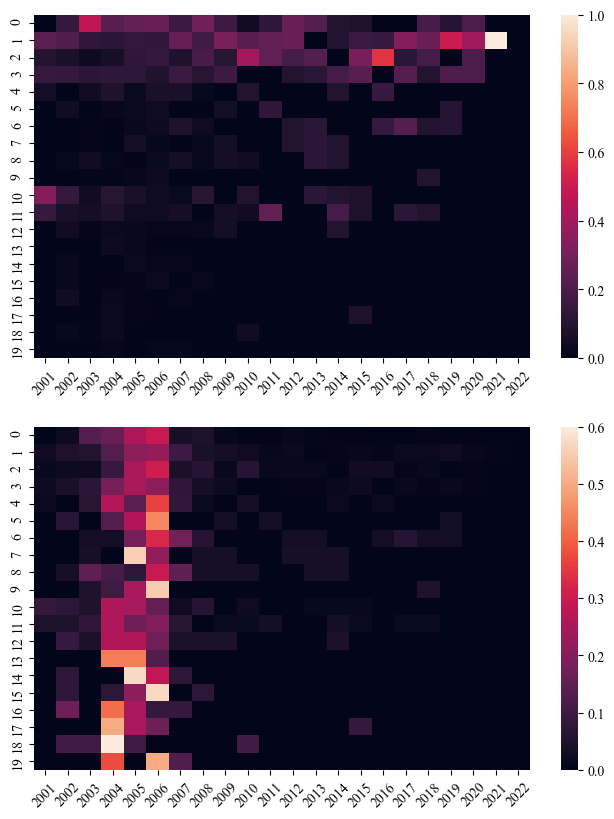

In [58]:
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import normalize

#normalize matrix
partition_matrix_normalised = normalize(partition_matrix, axis=0, norm='l1')
partition_matrix_normalisedrow = normalize(partition_matrix, axis=1, norm='l1')

fig, ax = plt.subplots(2,figsize=(8,10), dpi=100)
df_partition_matrix_normalised = pd.DataFrame(partition_matrix_normalised, index = np.arange(0,n_communities,1),
                  columns = [i for i in graphs.keys()])
sns.heatmap(df_partition_matrix_normalised, ax=ax[0])
ax[0].set_xticklabels([i for i in graphs.keys()],rotation=45)

df_partition_matrix_normalised = pd.DataFrame(partition_matrix_normalisedrow, index = np.arange(0,n_communities,1),
                  columns = [i for i in graphs.keys()])
sns.heatmap(df_partition_matrix_normalised, ax=ax[1])
ax[1].set_xticklabels([i for i in graphs.keys()],rotation=45)
plt.show()

In order to better capture communities in the distinct universes - and not just two overall communities being Marvel and DC - we separate the two by their 'universe' attribute. Here we take the 10 largest communities formed. The first 10 are Marvel communities and the last 10 are DC communities. Because we do an ensemble Louvain partitioning, we will see that a lot of nodes are not in these communities as they would shift too much between communities based on the Louvain seeding. We do this because Louvain is non-determenistic and we want to be sure that we don't see a lucky - or unlucky - seed determine the communities.

The first plot is normalised by years (columns) therefore, whenever we have a high value, we see that most of the nodes added that year was added to that community. Especially in the later years we do see a form of coral-growth in the Marvel communities. DC communities are overshadowed quite much by Marvel. This suggests that Marvel communities are far more popular and have many more nodes added to the communities during later years.

The second plot is normalised row-wise. Here we see the same trend as with everything else in this notebook... Let's try to look at 2009 and onwards and see if we find something more interesting. We will also add 0.5 to all values above 0 in the first plot. This way we can more easily see when there is a node added to a community!

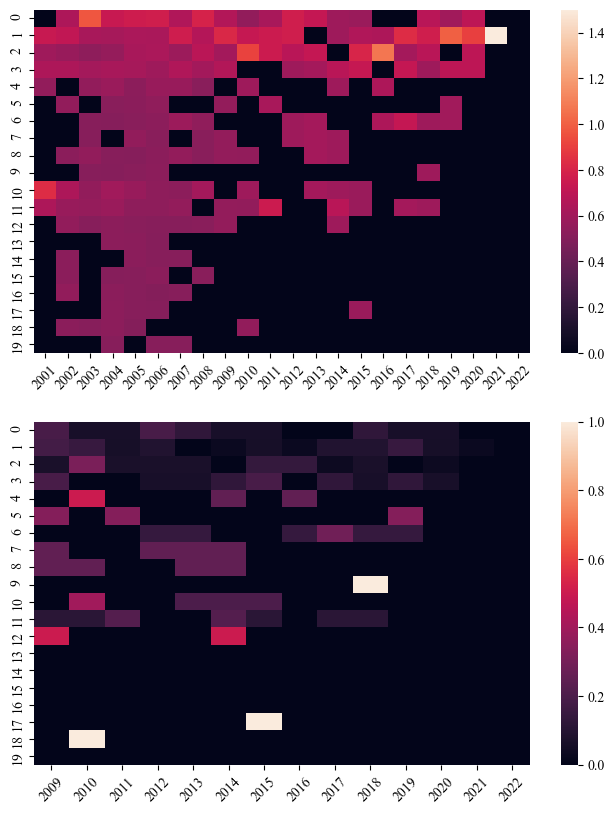

In [59]:
#normalize matrix
added = np.zeros(partition_matrix.shape)
for i in range(len(partition_matrix)):
    for j in range(partition_matrix.shape[1]):
        if partition_matrix[i,j]>0:
            added[i,j] = 0.5
partition_matrix_normalised = added + normalize(partition_matrix, axis=0, norm='l1')
partition_matrix_normalisedrow = normalize(partition_matrix[:,8:], axis=1, norm='l1')

fig, ax = plt.subplots(2,figsize=(8,10), dpi=100)
df_partition_matrix_normalised = pd.DataFrame(partition_matrix_normalised, index = np.arange(0,n_communities,1),
                  columns = [i for i in graphs.keys()])
sns.heatmap(df_partition_matrix_normalised, ax=ax[0])
ax[0].set_xticklabels([i for i in graphs.keys()],rotation=45)

df_partition_matrix_normalised = pd.DataFrame(partition_matrix_normalisedrow, index = np.arange(0,n_communities,1),
                  columns = [i for i in graphs.keys() if int(i)>=2009])
sns.heatmap(df_partition_matrix_normalised, ax=ax[1])
ax[1].set_xticklabels([i for i in graphs.keys() if int(i)>=2009],rotation=45)
plt.show()

The first plot indicates that there are just not that many nodes added to DC communities after 'the big boom' in Wikipedia. Some communities are more steadily added to - like community 1 - while others are added in small bursts - like community 4 or 9. 

We also see this in the second plot where communities 1 and 2 have a darker colour because they are more steadily added to while other communities have brighter colours meaning nodes are added to them in bursts.

In the project, we will investigate a way to test this with permutation. We will also look at revisions to see if the same behaviour occurs.

### Look at These Gifs!
Now we will check the size and strength of the communities we found!

First gif will show the size! Sorry for the code..

In [63]:
# get community names (largest degree node in each community)
d = dict(graphs[2022].degree())
sorted_degrees = {k: d[k] for k in sorted(d, key=d.get, reverse=True)}

community_names = {}
for key,value in sorted_degrees.items():
    try:
        com = partition_marvel[key]
        try:
            community_names[com]
        except:
            community_names[com] = key
    except:
        try:
            com = partition_dc[key]
            try:
                connumity_names[com]
            except:
                community_names[com+len(n_marvel_communities)] = key
        except:
            continue
    if len(community_names)==n_communities:
        break

In [64]:
def gen_colors(N:int,seed:int):
    '''
    N: number of colors you want to generate
    seed: seed
    colors: list of random hex colors
    '''
    import random
    random.seed(seed)
    colors = []
    for i in range(N):
        colors.append("#%06x" % random.randint(0, 0xFFFFFF))
    return colors

In [65]:
sourcenodes = pd.DataFrame(np.array(list(edgelist.groupby(['source','timestamp']).groups.keys())), columns = ['node','timestamp'])
targetnodes = pd.DataFrame(np.array(list(edgelist.groupby(['target','timestamp']).groups.keys())), columns = ['node','timestamp'])
#keep unique nodes and timestamps!
nodes =  pd.concat([sourcenodes,targetnodes]).drop_duplicates().reset_index(drop=True)

temp = meta_df.rename(columns={'WikiLink':'node'})
nodes = pd.merge(nodes, temp, on="node")
nodes = nodes.drop(columns=['Unnamed: 0'])
nodes.head()

count = 0
for year in graphs.keys():
    fig, ax = plt.subplots(figsize=(8,5),dpi=100)
    ax.bar([list(nodes[nodes['node']==list(community_names.values())[k]]['CharacterName'])[0] for k in range(len(list(community_names.values())))], 
           partition_matrix[list(community_names.keys()),:count].sum(1),
          color=gen_colors(n_communities,42))
    ax.set_ylabel("Counts")
    ax.set_xlabel("Community Name")
    ax.set_title(f"Size of Each Community in {year}")
    plt.ylim((0,320))
    plt.xticks(rotation=90)
    plt.savefig(f'plots/bar_plot_{year}.png', bbox_inches='tight')
    plt.close()
    count+=1

In [66]:
import imageio
import os
import re

with imageio.get_writer('bar_plot_finals.gif', mode='I', fps=0.5) as writer:
    for year in graphs.keys():
        image = imageio.imread(f'plots/bar_plot_{year}.png')
        writer.append_data(image)
    writer.close()

The gif looks like this:

<img src="bar_plot_finals.gif" width="750" align="center">

If we look at the last 10 communities - the DC communities - we might notice that neither Batman nor Superman is among the nodes with the highest degrees in the communities. The only reason for this is because they are so central that they are put into different communities at each run of our ensemble Louvain method and therefore are held out of the final communities; they do not meet the threshold of being in the same community 90% of the time.

To fix this we might lower the threshold, however, we would get more uncertain communities. Right now we are 90% certain that the communities we have found are true louvain communities.

Other than that the gif shows us the development of the communities over time - taking the size of the communities into account.

Next, we will look at the strength of the communities;

$$Strength(c)=\frac{intra}{(intra+inter)}$$

Where $intra$ is the number of links that are intra connected (connecting two nodes of the same community, $c$) and $inter$ are links that are inter connected (connecting two nodes with different communities).

In [83]:
strength_years = {}
for year in graphs.keys():
    intra_links = {}
    inter_links = {}
    strength = {}
    for key, value in partition_marvel.items():
        try:
            neighbors = list(graphs[year].neighbors(key)) + list(graphs[year].predecessors(key))
            for neighbor in neighbors:
                try:
                    if partition_marvel[neighbor] == value:
                        try:
                            intra_links[value] += 1
                            pass
                        except:
                            intra_links[value] = 1
                            pass
                    else:
                        try:
                            inter_links[value] += 1
                            pass
                        except:
                            inter_links[value] = 1
                            pass
                except:
                    try:
                        inter_links[value] += 1
                        pass
                    except:
                        inter_links[value] = 1
                        pass
        except:
            pass
    for key, value in partition_marvel.items():
        try:
            strength[value] = intra_links[value]/ (intra_links[value]+inter_links[value])
        except:
            strength[value] = 0
    #DC
    for key, value in partition_dc.items():
        value = value + k
        try:
            neighbors = list(graphs[year].neighbors(key)) + list(graphs[year].predecessors(key))
            for neighbor in neighbors:
                try:
                    if partition_dc[neighbor] == value-k:
                        try:
                            intra_links[value] += 1
                            pass
                        except:
                            intra_links[value] = 1
                            pass
                    else:
                        try:
                            inter_links[value] += 1
                            pass
                        except:
                            inter_links[value] = 1
                            pass
                except:
                    try:
                        inter_links[value] += 1
                        pass
                    except:
                        inter_links[value] = 1
                        pass
        except:
            pass
    for key, value in partition_dc.items():
        value = value+k
        try:
            strength[value] = intra_links[value]/ (intra_links[value]+inter_links[value])
        except:
            strength[value] = 0
    strength_years[year] = strength




In [84]:
count = 0
for year in graphs.keys():
    fig, ax = plt.subplots(figsize=(8,5),dpi=100)
    ax.bar([list(nodes[nodes['node']==list(community_names.values())[k]]['CharacterName'])[0] for k in range(len(list(community_names.values())))], 
           list(strength_years[year].values()),
          color=gen_colors(n_communities,42))
    ax.set_ylabel("Strength")
    ax.set_xlabel("Community Name")
    ax.set_title(f"Strength in Each Community in {year}")
    plt.ylim((0, 1)) 
    plt.xticks(rotation=90)
    plt.savefig(f'plots/bar_plot_strength_{year}.png', bbox_inches='tight')
    plt.close()
    count+=1

In [86]:
import imageio
import os
import re

with imageio.get_writer('bar_plot_strength_final.gif', mode='I', fps=0.5) as writer:
    for year in graphs.keys():
        image = imageio.imread(f'plots/bar_plot_strength_{year}.png')
        writer.append_data(image)
    writer.close()

The gif looks like this:

<img src="bar_plot_strength_final.gif" width="750" align="center">

The visualisation of the community strength evolution illustrates that the majority of communities have a strength below $0.5$, which implies that there is more interconnectivity than intraconnectivity. However, a few communities consistently demonstrate a strength greater than $0.5$, indicating more intraconnectivity. The ensemble Louvain method shuns out nodes that might have otherwise been included in the communities. This decreases the strength of all communities, and setting the percentage for which nodes are accepted into communities will increase the strengths but decrease the certainty of the communities.

## Node Migration
The following section will investigate how the communities evolve in a temporal network by visualising the node migration between the communities determined at each snapshot. Therefore, an independent community detection will be conducted at each yearly static snapshot of the temporal network. 

The purpose of this investigation is to analyse how the temporal changes in the network impact the communities with an emphasis on growth/contraction, merging/splitting and birth/death of the superhero communities in the Wikipedia network through time. Visualising the node migration in an easily interpretable manner may help facilitate a greater understanding of which time-periods drastic changes in the community structures emerge throughout the lifespan of the temporal network. This understanding would then be beneficial to generate new questions and narrow the scope to significant periods.

Determining the node migration based on independent community detections relies on a robust community detection algorithm that would satisfyingly identify the same communities if the wiring of the network remains unchanged. Hence, we decided to investigate different approaches to increase the stability of well-established community detection methods. One solution is to utilise an ensemble approach, in which several runs of a specific community detection algorithm are used to determine the communities. More specifically, we adopt the ensemble Infomap which is a modification of the ensemble Louvain algorithm presented in [1]:

    1) Run N trials of Infomap using the same network

    2) Create a new undirected network

    3) Add edge between nodes u and v if the number of cooccurence in a specific community exceed threshold (e.g 90%) 

    4) Determine the connected components in the new network.


The connected components of the new network correspond to the communities of the original network because, for each iteration, the Infomap assigns every node to a single community. Hence, if a threshold of 90% is used, then if an edge is added in the new network, it will imply that the two nodes u and v cooccur in the same community in more than 90% of the realisations. For the remaining realisations in which u and v can be assigned different communities, it can not be frequent enough to exceed the threshold (90% + 90% > 100%). Hence, the resulting connected components will correspond to the communities of the network.




In [70]:
import random
import plotly.express as px
from infomap import Infomap
import plotly.graph_objects as go
from collections import Counter
from collections import defaultdict
import string
import networkx as nx
import numpy as np
from tqdm import tqdm
from itertools import combinations
import os
import pandas as pd

In [71]:

#Getting data
df_marvel = pd.read_csv("files/marvel.csv", index_col=0, encoding='utf8')
df_marvel = df_marvel[df_marvel["WikiLink"].notna()]
df_dc = pd.read_csv("files/dc.csv", index_col=0, encoding='utf8')
df_dc = df_dc[df_dc["WikiLink"].notna()]
df_marvel['universe'] = 'Marvel'
df_dc['universe'] = 'DC'
df = pd.concat([df_marvel, df_dc], ignore_index=True, axis=0)

edgelist = pd.read_csv("corrected_edgelist.csv")
temp = pd.merge(edgelist, df, left_on='source', right_on='WikiLink')
temp = temp.rename(columns={"universe":"source universe"})
temp = temp.drop(columns=['CharacterName', 'WikiLink'])
temp = pd.merge(temp, df, left_on='target', right_on='WikiLink')
temp = temp.rename(columns={"universe":"target universe"})
temp = temp.drop(columns=['CharacterName', 'WikiLink'])
expanded_edgelist = temp.copy()

### Stability of Ensemble Infomap

To investigate the usefulness of adopting an ensemble community detection approach, we examined the robustness of the partitions obtained with varying amounts of trials in the ensemble Infomap algorithm. More specifically, the ensemble Infomap was computed ten times with the number of trials equal to 1, 25, 50, 75, and 100. Subsequently, the adjusted rand index (ARI) was pairwisely determined for the obtained ten partitions at a given number of trials to evaluate the stability performance with varying number trials. To conduct this investigation the network at $t_{N}$ was used.

In [72]:
edgelist_temp = expanded_edgelist[expanded_edgelist.timestamp==2022]
G_2022 = nx.from_pandas_edgelist(edgelist_temp, create_using = nx.DiGraph)

In [73]:

def ensemble_infomap(graph, N, k=None, threshold = 0.9, verbose=False, seed=0):
    '''
    1) run several trials of Infomap on the same network,
    2) built a new network where a pair of the original nodes is linked if their total co-membership across all the Louvain trials is above a given threshold (e.g., 90%),
    3) identify the disjoints sets which represent the resulting communities.'''
    
    #preperation
    graph = nx.convert_node_labels_to_integers(graph, label_attribute="org_name")
    names = nx.get_node_attributes(graph, "org_name")
    
    #step 1
    tot_communities = []
    for iter_ in tqdm(range(N), disable=not verbose):
        
        im = Infomap(directed=True, silent=not verbose, seed=seed+iter_) #Using new seed
        for edge in graph.edges():
            im.addLink(*edge)
        im.run()
        communities = {}
        for node in im.tree:
            if node.is_leaf:
                communities[names[node.node_id]] = node.module_id
        tot_communities.append(communities)
    
    #preperation
    graph = nx.relabel_nodes(graph, names)
    
    #step 2
    G_new = nx.Graph()
    G_new.add_nodes_from(list(graph.nodes))
    node_pairs = combinations(list(graph.nodes), 2)
    for (u,v) in tqdm(node_pairs, disable=not verbose):
        co_occurence = 0
        for partitions in tot_communities:
            if partitions[u] == partitions[v]: 
                co_occurence += 1
        if co_occurence/N > threshold:
            G_new.add_edge(u, v)
        
        
    #step 3
    if k == None:
        k = nx.number_connected_components(G_new)
    k_greatest_components = {i: list(community) for i, community in enumerate(sorted(nx.connected_components(G_new), key=len, reverse=True)[:k])}
    
    
    return k_greatest_components


In [74]:
from sklearn.metrics import adjusted_rand_score
import scipy.stats as st
from itertools import combinations

N = 10
avg_ARI = []
CI_ARI = []

for n in tqdm(np.linspace(1,100,5)):
    partitions = []
    
    for idx in range(N):
        communities = ensemble_infomap(graph=G_2022, N=int(n), threshold=0.9, verbose=False, seed=(idx+N))
        #Reversing dictionary
        reversed_communities = {}
        for u, v in communities.items():
            for node in v:
                reversed_communities[node] = u 
        
        partitions.append(list(reversed_communities.values()))
        #partitions = list(communities.values())
        
    partition_pairs = list(combinations(partitions, 2))
    
    ARIs = []
    for (u, v) in partition_pairs:
        #print(adjusted_rand_score(u,v))
        ARIs.append(adjusted_rand_score(u,v))
        
    avg_ARI.append(np.mean(ARIs))
    #std_ARI.append(np.std(ARIs))
    CI_ARI.append(st.t.interval(confidence=0.95, df=N-1,
                        loc=np.mean(ARIs),
                        scale=st.sem(ARIs)))
    

100%|████████████████████████████████████████████| 5/5 [18:24<00:00, 220.83s/it]


The following figure illustrates the average pairwise ARI as function of the number of trials. The average pairwise ARI is presented with a 95% confidence interval.

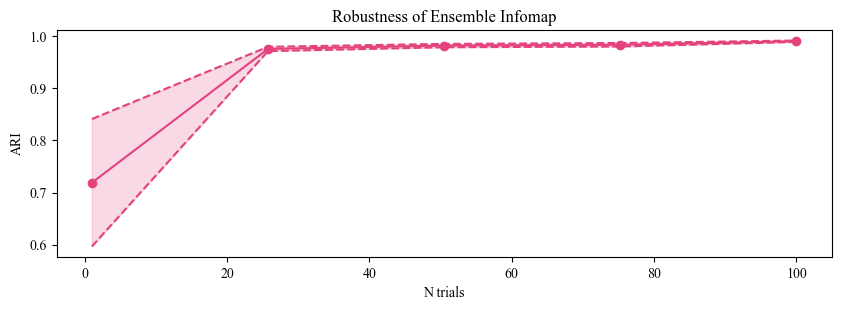

In [75]:
fig, ax = plt.subplots(figsize=(10,3), dpi=100)
xs = np.linspace(1,100,5)
ax.plot(xs, avg_ARI, '-o', label="RAA", color='#e3427d')
ax.fill_between(xs,
                 y1 = [x for (x,y) in CI_ARI],
                 y2 = [y for (x,y) in CI_ARI],
                 color='#e3427d', alpha=0.2)
ax.plot(xs, [x for (x,y) in CI_ARI], '--', color='#e3427d')
ax.plot(xs, [y for (x,y) in CI_ARI], '--', color='#e3427d')
ax.set_xlabel("N trials")
ax.set_ylabel("ARI")
ax.set_title("Robustness of Ensemble Infomap")
plt.show()
    

The figure demonstrates that the robustness of Ensemble Infomap significantly increases with the number of trials. Furthermore, the results also indicates that increasing the number of trials above 25 only leads to a marginal increase in the stability of the partitions in regards to this specific network.

### Node Migration Visualisation

The previous section demonstrated the usefulness of the proposed ensemble Infomap algorithm. Hence, the ensemble method will be used to conduct the independent community detections in the following creation of the node migration visualisation.

The initial step in creating the visualisation is to compute the k-greatest communities at each time step. The following step is then to create edges between communities, for instance, at time step $t_i$ and $t_{i+1}$ if a node in a community at $t_i$ also is present in a community at $t_{i+1}$. To keep the visualisation manageable only a single edge will be created between a pair of communities. However, the edge weight will correspond to the number of nodes migrating from one community to another.

In [76]:
def sankey(t0, tN, edgelist, k, N, threshold, verbose=False):

    #Creating networkx graph objects for each year
    networks = []
    tot_communities = []
    number_communities = {}
    for year in [t0 + i for i in range(tN-t0 + 1)]:
        edgelist_temp = edgelist[edgelist.timestamp==year]
        attrs_temp = {row.source: {'group': row['source universe']} for idx, row in edgelist_temp.iterrows()}
        G_temp = nx.from_pandas_edgelist(edgelist_temp, create_using = nx.DiGraph)

        #Adding attributes
        nx.set_node_attributes(G_temp, attrs_temp)
        
        #Fixing issue with nodes missing universe data
        missing_attrs = {row.target: {'group': row['target universe']}for idx, row in edgelist_temp[edgelist_temp['target'].isin([u for u,v in G_temp.nodes(data=True) if not v])].iterrows()}
        nx.set_node_attributes(G_temp, missing_attrs)


        #Removing singleton nodes
        G_temp.remove_nodes_from(list(nx.isolates(G_temp)))
        
        #Calling ensemble infomap to compute communities
        communities = ensemble_infomap(graph=G_temp, N=N, k=k, threshold=threshold, verbose=verbose)
        number_communities[year] = len(list(communities.keys()))
        tot_communities.append(communities)
        
    edges = []
    plot_names = []
    for idx, (com_t0, com_tN) in enumerate(zip(tot_communities, tot_communities[1:])):
        
        if idx == 0:
            prev_max = 0
        
        idx_map_t0 = dict(zip(list(com_t0.keys()),
                           [i for i in range(prev_max, prev_max + len(list(com_t0.keys()))+1)]))
        #updating idx for next iter
        prev_max = max(idx_map_t0.values())+ 1

        idx_map_tN = dict(zip(list(com_tN.keys()),
                           [i for i in range(prev_max, prev_max + len(com_tN.keys())+1)]))
        
        for u,v in com_t0.items(): #t0
            for node in v:
                for i,j in com_tN.items(): #tN
                    if node in j:
                        edges.append((idx_map_t0[u],idx_map_tN[i]))

                        break

        plot_names.append(list(idx_map_t0.values()))
    plot_names.append(list(idx_map_tN.values()))
    plot_names = [item for sublist in plot_names for item in sublist]
    
    
    source = []
    target = []
    value = []
    for (u,v), w in dict(Counter(edges)).items():
        source.append(u)
        target.append(v)
        value.append(w)

    #Fixing plotly error
    for plot_name in plot_names:
        if plot_name not in target and plot_name not in source:
            source.append(plot_name)
            target.append(plot_name)
            value.append(1)
    
    #Determining positions - has to be between 0-1
    y = []
    x = []
    year_range = np.linspace(0, 1, len(number_communities.values()))
    
    
    for idx, number in enumerate(number_communities.values()):
        y.append(np.linspace(0, 1, number))
        x.append([year_range[idx]]*number) 
        
    x_pos = [item for sublist in x for item in sublist]
    y_pos = [item for sublist in y for item in sublist]
    
    fig = go.Figure(data=[go.Sankey(
            arrangement = "snap",
            node = dict(
                pad = 10,
                thickness = 15,
                line = dict(color = "black", width=0.5),
                label = plot_names,
                x = x_pos,
                y = y_pos,
                color = "darkblue"

            ),
            link = dict(
                source = source,
                target = target,
                value = value,
                color = [
                        px.colors.qualitative.Plotly[i % len(px.colors.qualitative.Plotly)]
                        for i in source
                       ]
            )
    )])
    
    fig.update_layout(title_text=f"Community Evolution {t0}-{tN}", font_size=15, 
                      yaxis={'visible': False, 'showticklabels': False},
                      xaxis={'visible': False, 'showticklabels': False})
    
    for x_coordinate, column_name in enumerate([f"{t0+i}" for i in range(tN-t0 + 1)]):
        fig.add_annotation(
              x=x_coordinate,#Plotly recognizes 0-5 to be the x range.

              y=1.075,#y value above 1 means above all nodes
              xref="x",
              yref="paper",
              text=column_name,#Text
              showarrow=False,
              font=dict(
                  family="Times New Roman",
                  size=16,
                  color="black"
                  ),
              align="left",
              )

    fig.add_annotation(text='Self-loops indicate no node migration to the previous or next K-greatest communities', 
                    align='left',
                    showarrow=False,
                    xref='paper',
                    yref='paper',
                    x=0,
                    y=-0.1,
                    bordercolor='black',
                    borderwidth=1,
                    font=dict(
                          family="Times New Roman",
                          size=12,
                          color="black"
                  ))
    
    return fig, tot_communities

The following visualisation demonstrate the node migration of the 10 greatest communities within the time-period 2015-2022. To both demonstrate the effect of ensemble Infomap and to keep the running time of the notebook convenient, the following demonstration will use the original Infomap without ensemble:

In [77]:
fig, temp = sankey(t0=2015, tN=2022, k=10, edgelist=expanded_edgelist, N=1, threshold=0.9, verbose=False)

In [78]:
fig.show()

To visualise the node migration throughout the entire timeframe (2001-2022), the following figures demonstrate the intervals (2001-2008), (2008-2015), and (2015-2022). The figures are generated using the 10 greatest communities and an ensemble Infomap using 100 trials:

In [79]:
from IPython.display import IFrame

In [80]:
IFrame(src='communitiy_evolve_sankey_2001_2008.html', width=1000, height=450)

In [81]:
IFrame(src='communitiy_evolve_sankey_2008_2015.html', width=1000, height=450)

In [82]:
IFrame(src='communitiy_evolve_sankey_2015_2022.html', width=1000, height=450)

> **_Note:_** The colours of edges do not correspond to a specific community. They are added to make it easier to see which outgoing edges correspond to a given community.

Restricting the attention to the first illustration, which depicts the community evolution from 2001 to 2008, this period can be characterised by rapid community structure changes, with multiple examples of apparent growth, merging, splitting, birth, and death of communities. The only community evolution characteristic that does not seem to be present within this timeframe is the contraction of communities. Furthermore, some of the communities also appear to demonstrate relatively continuous growth from 2001 to 2008. A striking shift in the community structure seems to happen from 2006 to 2007, where the greatest community in 2006 splits into multiple communities in 2007. A further investigation of why and what rewiring of the network diagram causes this community behaviour would be interesting.

The community evolution of the k-greatest communities from 2008 to 2015 is characterised by generally more stability, with fewer examples of splitting, merging etc., compared with the structural changes present from 2001 to 2008. Lastly, the community evolution from 2015 to 2022 also demonstrates generally stable clusters with a decrease in node migration between different communities compared with the previous timeframes.

Thus, the depicted evolution demonstrates that the stability of the k-greatest communities increases with time. This finding aligns with the expectations based on the yearly number of revisions distribution of the Wikipedia pages previously illustrated, which demonstrated a significant decrease in the number of revisions after the year 2005.

### Robustness of Community Assignment
As previously mentioned, the node migration visualisations indicated that the stability of k-greatest communities increased with time. Concerning this finding, One hypothesis to explain this trend could be as previously mentioned that the decreasing number of revisions causes this behaviour. Another hypothesis could be that due to the increasing number of edges each year, presented previously, the amount of rewiring in the network necessary to alter a node's community assignment increases proportionally. Hence, it would be interesting to investigate if this trend potentially could be explained by this second hypothesis. One possible approach to verify or falsify this hypothesis would be to examine the number of randomly added edges required to change the community assignment of a given node as a function of the number of edges in the network.

# Further Considerations

There are still things left to discover about this network;

> - How is the metadata put together? Would it make sense to adjust the Jaccard similarity to get more certain about the data we have?
> - We need to do some statistical tests on how the network evolves. We can do this with permutation tests which should allow us to see if the network grows in a coral fashion at times.
> - Why does the stability of the communities increase with time? Could it be because the number of revisions of the Wikipedia pages decreases after 2007? Or could it be because the required rewiring of the network to reassign a node's community increases with the size of the network? Maybe a third option is the explanation, for instance, that the content of Wikipedia pages converges towards a collective agreement.

We intend to further investigate the questions that have been raised throughout this notebook by combining network science and text mining tools in the final project.

# Summary / Conclusion

Let's conclude the distinct sections of this notebook;
> - We saw that both the number of nodes, edges and the average degree of the network increased dramatically between 2004 and 2007. This correlates with the general trend of article revisions in [Wikipedia](https://en.wikipedia.org/wiki/Wikipedia:Statistics).
> - Several of the results presented in this notebook have demonstrated that the structure of the temporal network tends to converge towards a more stable structure when time passes in terms of the:
>  - Degree distribution
>  - Eigenvector centralityy
>  - Communities (Node migration)
>  - Influence of node properties such as gender
> - However, the results have also demonstrated that external factors can influence the number of revisions of a Wikipedia page e.g. Black Panther. It could be interesting to investigate if these external factors' influence on revisions also are visible in the network structure.
> - The betweenness centrality of female superheroes has increased with time and becomes significantly different from a random gender assignment after 2006.
> - However, the investigation of centrality evolution also demonstrated that non-gender specified superheroes on Wikipedia had a significantly lower betweenness centrality than a random gender assignment. This could indicate bias in the incomplete gender superhero lists gathered from Wikipedia, which might only contain generally popular superheroes.
> - If we are to believe the race labels, black and Asian seem to have significantly more betweenness centrality than that of a permuted graph. This is not the case for Latinos. Because of the way we collected the metadata on these attributes, however, we are not certain that this is to be believed as the unlabeled data had a significantly lower betweenness centrality than a permuted graph. The unlabeled data should include big profiles such as Batman, Spiderman and Superman which are nodes with huge degrees and probably huge betweenness centrality as well, assuming that betweenness centrality functions as a proxy of importance in a specific universe.
> - It appears that a few communities in periods grow in bursts resembling a coral-like growth. However, if this trend is significant and can be used to explain the evolution of the communities will be further investigated in the final project.



# References
[1] Evkoski B, Mozetič I, Ljubešić N, Kralj Novak P (2021) Community evolution in retweet networks. PLOS ONE 16(9): e0256175.
<br >
[2] Heaberlin, Bradi, and Simon DeDeo. 2016. "The Evolution of Wikipedia’s Norm Network" Future Internet 8, no. 2: 14. https://doi.org/10.3390/fi8020014 
<br >
[3] Barabási, Albert-László. 2015. Network science. Cambridge University Press. http://networksciencebook.com/

